In [1]:
import squidpy as sq
import scanpy as sc
import pandas as pd 
import os 

In [4]:
import numpy as np 

In [2]:
import CellNeighborEX
print('Version:', CellNeighborEX.__version__)

Version: 0.0.5


In [5]:
spdatapath='./inputQuery/'
ad_spatial_ori=sc.read_h5ad(spdatapath+'common_counts_sp.h5ad')

coordinate = pd.read_csv(spdatapath+'tissue_positions_list.csv')
coordinate=coordinate.to_numpy()

print(coordinate.shape,ad_spatial_ori)

df=pd.read_csv(spdatapath+'MNN_based_annotations/3_nico_annotation_ct_name.csv')
sc_ctype_name=df.to_numpy()

df=pd.read_csv(spdatapath+'MNN_based_annotations/3_nico_annotation_cluster.csv')
nico_cluster=df.to_numpy()
cellname=nico_cluster[:,0]

print("equal",np.array_equal(cellname,ad_spatial_ori.obs_names))


d={}
for i in range(len(sc_ctype_name)):
    d[i]=sc_ctype_name[i][1]

ctname=[]
for i in range(len(cellname)):
        ctname.append( d[ nico_cluster[i,1]])

ad_spatial_ori.obs['nico_ct']=ctname

sc_ctype_name=coordinate[:,0]
d={}
for i in range(len(sc_ctype_name)):
    d[sc_ctype_name[i]]=i

index=[]
for i in range(len(cellname)):
    index.append( d[ cellname[i]])

coordinate1=coordinate[index]
print("equal",np.array_equal(cellname,coordinate1[:,0]),coordinate1.shape)

#because it is 2d tissue slide so only upload the X and Y coordiante
ad_spatial_ori.obsm['spatial']=coordinate1[:,[1,2]].astype(float)
adata=ad_spatial_ori
sample=[]
for i in range(len(ad_spatial_ori.obs_names)):
    sample.append('batch0')


adata.obs['sample']=np.array(sample)
adata.obs['sample']=pd.Categorical(adata.obs['sample'])

print('1',adata)

index=[]
for i in range(len(ctname)):
    flag=1
    if adata.obs['nico_ct'][i]=='NM':
        flag=0
    if adata.obs['nico_ct'][i]=='HsPCs':
        flag=0
    if adata.obs['nico_ct'][i]=='Basophils':
        flag=0
    if adata.obs['nico_ct'][i]=='NK cells':
        flag=0
    if flag==1:
        index.append(i)


adata=adata[index]
print('2',adata)

(395215, 3) AnnData object with n_obs × n_vars = 391678 × 342
    obs: 'n_counts'
equal True
equal True (391678, 3)
1 AnnData object with n_obs × n_vars = 391678 × 342
    obs: 'n_counts', 'nico_ct', 'sample'
    obsm: 'spatial'
2 View of AnnData object with n_obs × n_vars = 374905 × 342
    obs: 'n_counts', 'nico_ct', 'sample'
    obsm: 'spatial'


AnnData object with n_obs × n_vars = 19416 × 351
    obs: 'Area', 'celltype_mapped_refined'
    uns: 'celltype_mapped_refined_colors'
    obsm: 'X_umap', 'spatial'

In [6]:
# Create a dataframe from the provided AnnData object.
# coord_key (str): Key to access the spatial coordinates in `adata.obsm`.
# celltype_key (str): Key to access the cell type information in `adata.obs`.
df =  CellNeighborEX.neighbors.create_dataframe(adata, coord_key='spatial', celltype_key='nico_ct')



In [7]:
df

barcode       celltype1            x            y  first_type  \
0            cell0          Hep_MC  4704.016512  9503.786543          -1   
1            cell1  Stellate cells  4730.710462  9503.968699          -1   
2            cell2          Hep_MC  4639.571937  9428.907312          -1   
3            cell3          Hep_P1  4625.214862  9421.014028          -1   
4            cell4          Hep_MC  4787.607399  9522.299180          -1   
...            ...             ...          ...          ...         ...   
374900  cell395210          Hep_P1  8955.301563    65.349346          -1   
374901  cell395211           LSECs  9015.424090    74.755519          -1   
374902  cell395212          Hep_P2  8914.041696   110.864912          -1   
374903  cell395213          Hep_P2  8912.058525    97.377087          -1   
374904  cell395214      Fibroblast  9039.503644    97.852707          -1   

        second_type celltype2  prop1  prop2  
0                -1        NA    1.0    0.0  
1                -1        NA    1.0    0.0  
2                -1        NA    1.0    0.0  
3                -1        NA    1.0    0.0  
4                -1        NA    1.0    0.0  
...             ...       ...    ...    ...  
374900           -1        NA    1.0    0.0  
374901           -1        NA    1.0    0.0  
374902           -1        NA    1.0    0.0  
374903           -1        NA    1.0    0.0  
374904           -1        NA    1.0    0.0  

[374905 rows x 9 columns]

Calculating closest distances: 100%|█| 374905/374905 [23:40:29<00:00,  4.40it/s]


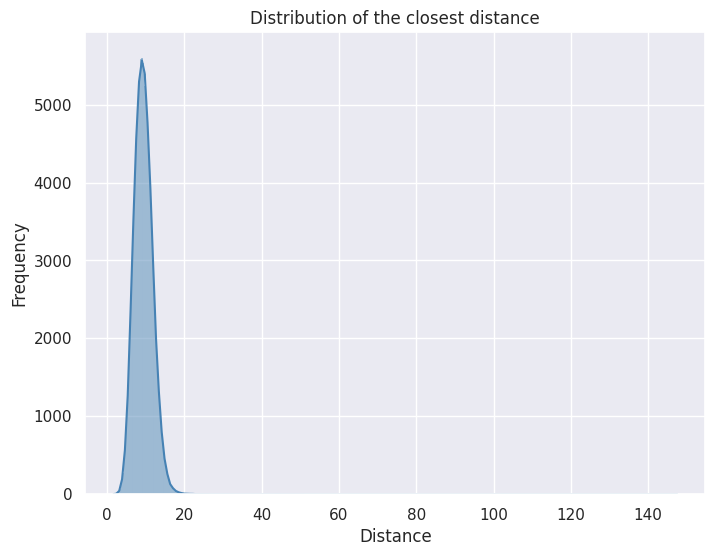

In [8]:
# (Optional) Calculate the closest distance between cells.
# If save=True, the result (closest_distance_distribution.pdf) is saved in the "neighbor_info" folder in the root directory.
closest_distances = CellNeighborEX.neighbors.calculate_closest_distance(df, save=True)

In [9]:
import pickle 
fout='save_closest_dist.p'
myfile=open(fout,'wb')
pickle.dump(closest_distances,myfile)
myfile.close()

In [10]:
# Find immediate neighbors using Delaunay triangulation and retrieve the spatial connectivity matrix.
matrix = CellNeighborEX.neighbors.detect_neighbors(adata, coord_key='spatial', type='generic', knn=None, radius_value=None, delaunay=True)

# Calculate the number of neighbors for each cell.
neiNum = CellNeighborEX.neighbors.get_neighbors(matrix)

In [12]:
matrix

<374905x374905 sparse matrix of type '<class 'numpy.float64'>'
	with 2249334 stored elements in Compressed Sparse Row format>

In [14]:
df['celltype1']

0                 Hep_MC
1         Stellate cells
2                 Hep_MC
3                 Hep_P1
4                 Hep_MC
               ...      
374900            Hep_P1
374901             LSECs
374902            Hep_P2
374903            Hep_P2
374904        Fibroblast
Name: celltype1, Length: 374905, dtype: object

In [11]:
# Processes the dataframe by adding additional columns based on the neighbor matrix and neighbor counts.
# If save=True, the result (df_processed.csv) is saved in the "neighbor_info" folder in the root directory.
df_processed = CellNeighborEX.neighbors.process_dataframe(df, matrix, neiNum, save=True)

/home/sclab/miniconda3/envs/cellneighborex/lib/python3.10/site-packages/CellNeighborEX/neighbors.py:237: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['celltype2'][i] = get_neighboring_cell_type(neiType=df['neiType'][i], celltype1=df['celltype1'][i])
/home/sclab/miniconda3/envs/cellneighborex/lib/python3.10/site-packages/CellNeighborEX/neighbors.py:235: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['celltype2'][i] = df['celltype1'][i]


AttributeError: Can only use .cat accessor with a 'category' dtype

In [ ]:
df_processed.head(5) # celltype1 is the cell type of a centered cell, and celltype2 is its neighboring cell type. 
#first_type and second_type are numbers correspond to the cell types.

In [ ]:
###### before above I ran it ##############

In [15]:
# All categorzied files (index_, matchComb_, neiCombUnique_, prop_ .csv) are saved in the "categorized_data folder" in the root directory.
CellNeighborEX.categorization.generate_input_files(data_type = "Image", df = df_processed, sample_size=30, min_sample_size=1)



/home/sclab/miniconda3/envs/cellneighborex/lib/python3.10/site-packages/CellNeighborEX/categorization.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['integrated'][idx] = df['celltype1'][idx] + '+' + df['celltype2'][idx]
/home/sclab/miniconda3/envs/cellneighborex/lib/python3.10/site-packages/CellNeighborEX/categorization.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['index_boolean'][list_index1[yy]] = 1
/home/sclab/miniconda3/envs/cellneighborex/lib/python3.10/site-packages/CellNeighborEX/categorization.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame


In [17]:
# Normalize gene expression data.
barcodes = df_processed['barcode'].tolist()
adata = adata[barcodes, :]
sc.pp.normalize_total(adata, target_sum=1e4) # normlization
sc.pp.log1p(adata) # log-transform

/home/sclab/miniconda3/envs/cellneighborex/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [18]:
# Save the data into dataframes.
df_cell_id = pd.DataFrame(adata.obs.index)
df_gene_name = pd.DataFrame(adata.var.index)
df_log_data = adata.T.to_df()
df_log_data = df_log_data.reset_index(drop=True) # row indices are represented as numbers.

In [19]:
df_log_data.head(5)

embryo1_Pos0_cell10_z5  embryo1_Pos0_cell100_z2  embryo1_Pos0_cell102_z2  \
0                     0.0                 0.000000                 0.000000   
1                     0.0                 5.235994                 0.000000   
2                     0.0                 0.000000                 2.508516   
3                     0.0                 0.000000                 0.000000   
4                     0.0                 0.000000                 2.508516   

   embryo1_Pos0_cell102_z5  embryo1_Pos0_cell103_z5  embryo1_Pos0_cell105_z2  \
0                 0.000000                 3.241421                 0.000000   
1                 3.666001                 0.000000                 5.313305   
2                 2.998110                 3.914820                 0.000000   
3                 0.000000                 3.241421                 4.625072   
4                 0.000000                 3.241421                 0.000000   

   embryo1_Pos0_cell105_z5  embryo1_Pos0_cell106_z5  embryo1_Pos0_cell107_z2  \
0                 0.000000                 0.000000                 0.000000   
1                 5.476862                 0.000000                 4.296793   
2                 0.000000                 0.000000                 4.296793   
3                 0.000000                 3.745315                 0.000000   
4                 0.000000                 3.745315                 0.000000   

   embryo1_Pos0_cell108_z2  ...  embryo1_Pos28_cell79_z5  \
0                      0.0  ...                 0.000000   
1                      0.0  ...                 3.218108   
2                      0.0  ...                 3.218108   
3                      0.0  ...                 0.000000   
4                      0.0  ...                 0.000000   

   embryo1_Pos28_cell80_z5  embryo1_Pos28_cell83_z5  embryo1_Pos28_cell84_z5  \
0                      0.0                      0.0                 0.000000   
1                      0.0                      0.0                 0.000000   
2                      0.0                      0.0                 4.003023   
3                      0.0                      0.0                 0.000000   
4                      0.0                      0.0                 0.000000   

   embryo1_Pos28_cell89_z2  embryo1_Pos28_cell90_z2  embryo1_Pos28_cell90_z5  \
0                      0.0                 0.000000                 3.971863   
1                      0.0                 0.000000                 0.000000   
2                      0.0                 3.193126                 0.000000   
3                      0.0                 3.865539                 0.000000   
4                      0.0                 0.000000                 0.000000   

   embryo1_Pos28_cell92_z2  embryo1_Pos28_cell96_z2  embryo1_Pos28_cell97_z2  
0                      0.0                 0.000000                      0.0  
1                      0.0                 3.660449                      0.0  
2                      0.0                 0.000000                      0.0  
3                      0.0                 0.000000                      0.0  
4                      0.0                 0.000000                      0.0  

[5 rows x 11797 columns]

In [20]:
# The length of df_processed must be the same as the length of df_cell_id.
print(len(df_cell_id))
print(len(df_processed))

11797
11797


In [21]:
# Set argument values for CellNeighborEX.DEanalysis.analyze_data().
data_type = "Image"  # Image: image-based ST data, NGS: NGS-based ST data
lrCutoff = 0.4 # log ratio
pCutoff = 0.01 # p-value
pCutoff2 = 0.05 # false discovery rate
direction = 'up' # up: up-reguated genes, down: down-regulated genes
normality_test = False # True: depending on the result of the normality test, the statistical test is determined. If the data is normal, the parametric test is used. Otherwise, the non-parametric test is used.
                       # False: when sample size (number of cells/spots) is larger than 30, the parameteric test is used. Otherwise, the non-parametric test is used.
top_genes = 10 # Top 10 DEGs are annotated in the volcano plot.

In [28]:
path_categorization= './categorized_data/'

neighbor-dependent gene expression analysis:   0%|       | 0/36 [00:00<?, ?it/s]/home/sclab/miniconda3/envs/cellneighborex/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:1131: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  log_data_zvalue = (log_data_total - mean_values[:, np.newaxis]) / std_values[:, np.newaxis]


0


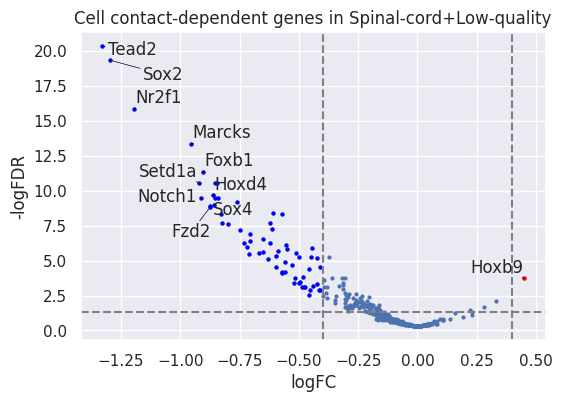

/home/sclab/miniconda3/envs/cellneighborex/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:660: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(a, fontsize=12)  # Sets the y-axis tick labels with fontsize 12


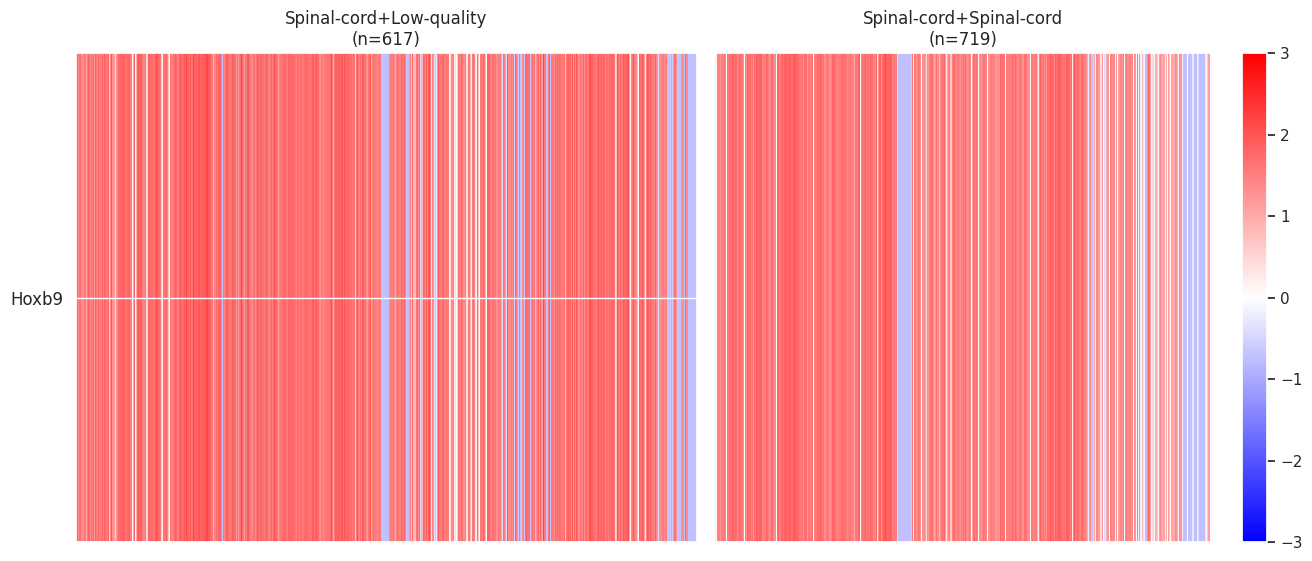

neighbor-dependent gene expression analysis:   3%| | 1/36 [00:01<00:55,  1.60s/i/home/sclab/miniconda3/envs/cellneighborex/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:1131: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  log_data_zvalue = (log_data_total - mean_values[:, np.newaxis]) / std_values[:, np.newaxis]


1


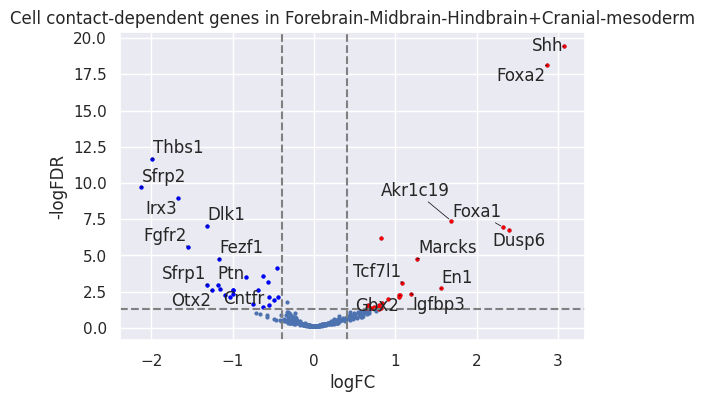

/home/sclab/miniconda3/envs/cellneighborex/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:660: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(a, fontsize=12)  # Sets the y-axis tick labels with fontsize 12


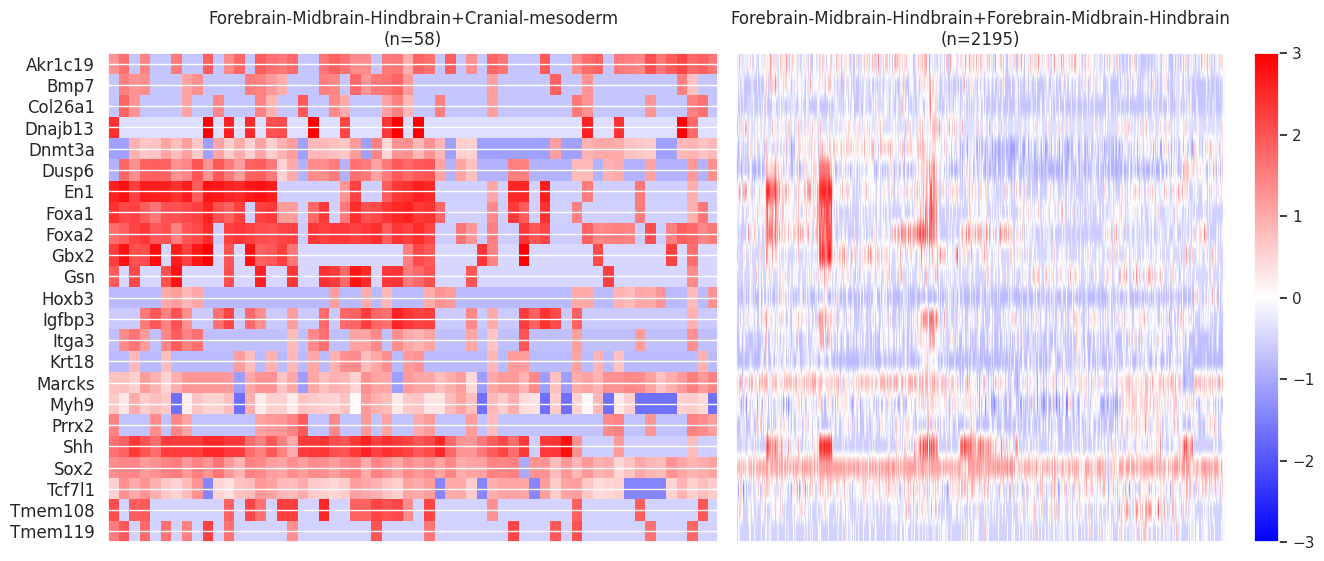

neighbor-dependent gene expression analysis:   6%| | 2/36 [00:03<01:05,  1.94s/i/home/sclab/miniconda3/envs/cellneighborex/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:1131: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  log_data_zvalue = (log_data_total - mean_values[:, np.newaxis]) / std_values[:, np.newaxis]


2


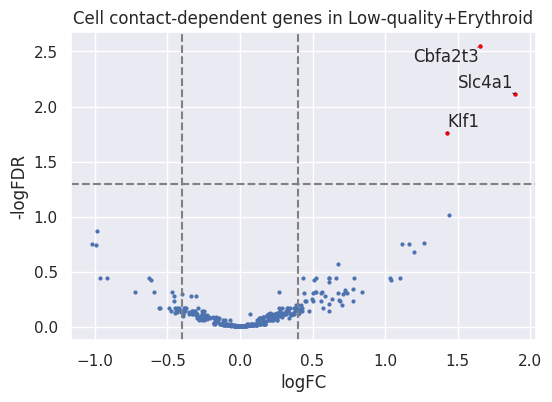

/home/sclab/miniconda3/envs/cellneighborex/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:660: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(a, fontsize=12)  # Sets the y-axis tick labels with fontsize 12


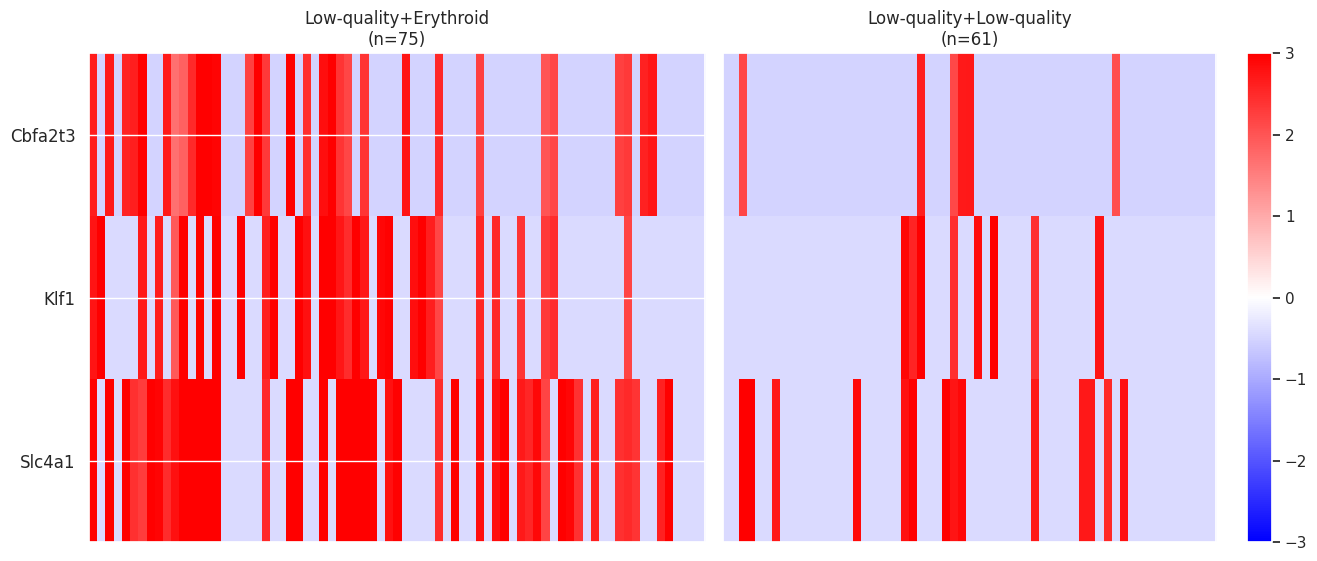

neighbor-dependent gene expression analysis:   8%| | 3/36 [00:05<00:54,  1.64s/i/home/sclab/miniconda3/envs/cellneighborex/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:1131: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  log_data_zvalue = (log_data_total - mean_values[:, np.newaxis]) / std_values[:, np.newaxis]


3


neighbor-dependent gene expression analysis:  11%| | 4/36 [00:05<00:37,  1.16s/i/home/sclab/miniconda3/envs/cellneighborex/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:1131: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  log_data_zvalue = (log_data_total - mean_values[:, np.newaxis]) / std_values[:, np.newaxis]


4


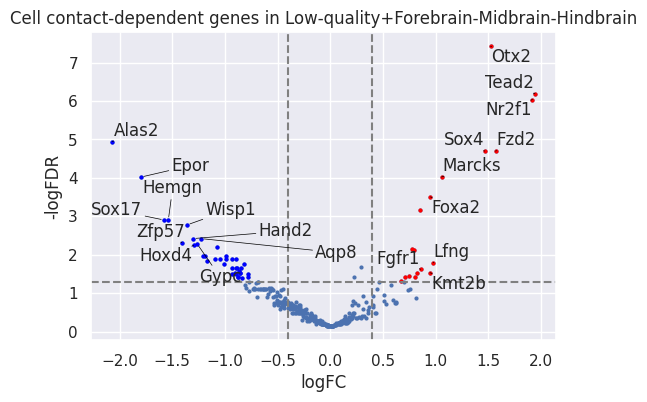

/home/sclab/miniconda3/envs/cellneighborex/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:660: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(a, fontsize=12)  # Sets the y-axis tick labels with fontsize 12


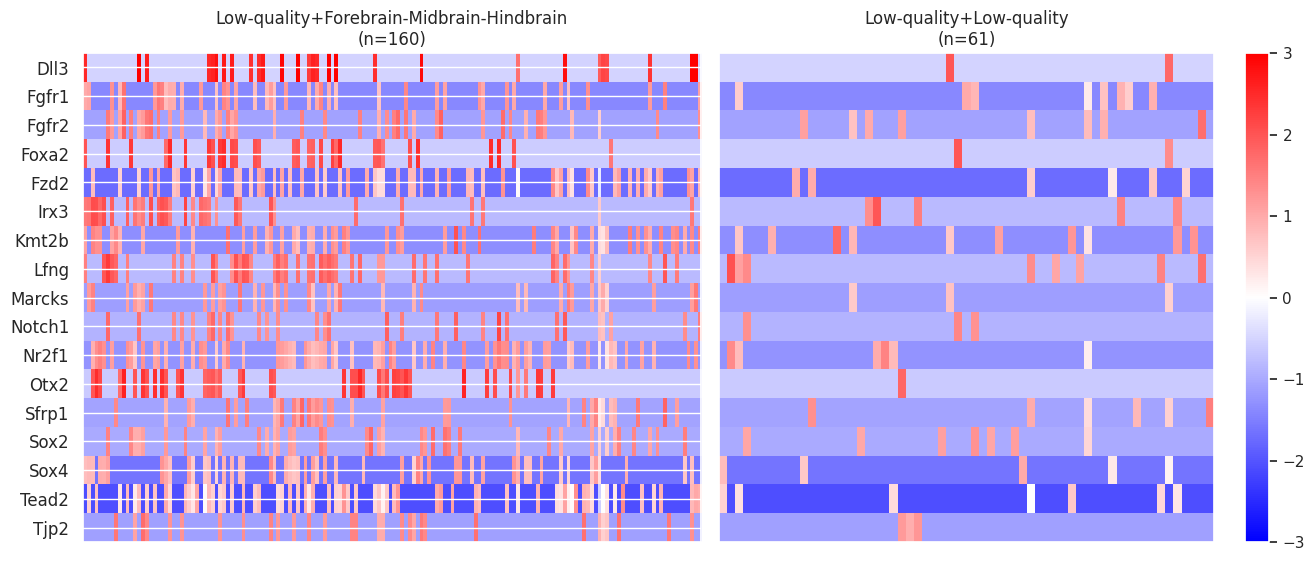

neighbor-dependent gene expression analysis:  14%|▏| 5/36 [00:09<01:06,  2.14s/i/home/sclab/miniconda3/envs/cellneighborex/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:1131: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  log_data_zvalue = (log_data_total - mean_values[:, np.newaxis]) / std_values[:, np.newaxis]


5


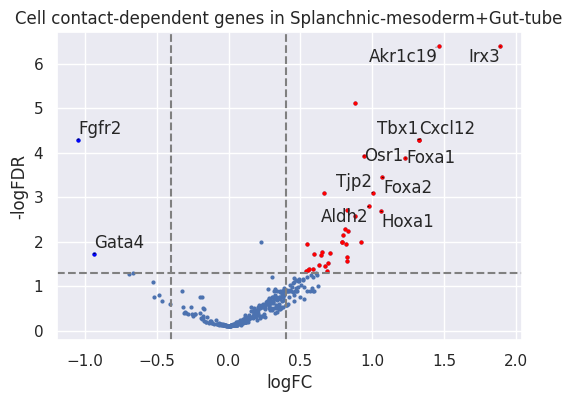

/home/sclab/miniconda3/envs/cellneighborex/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:660: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(a, fontsize=12)  # Sets the y-axis tick labels with fontsize 12


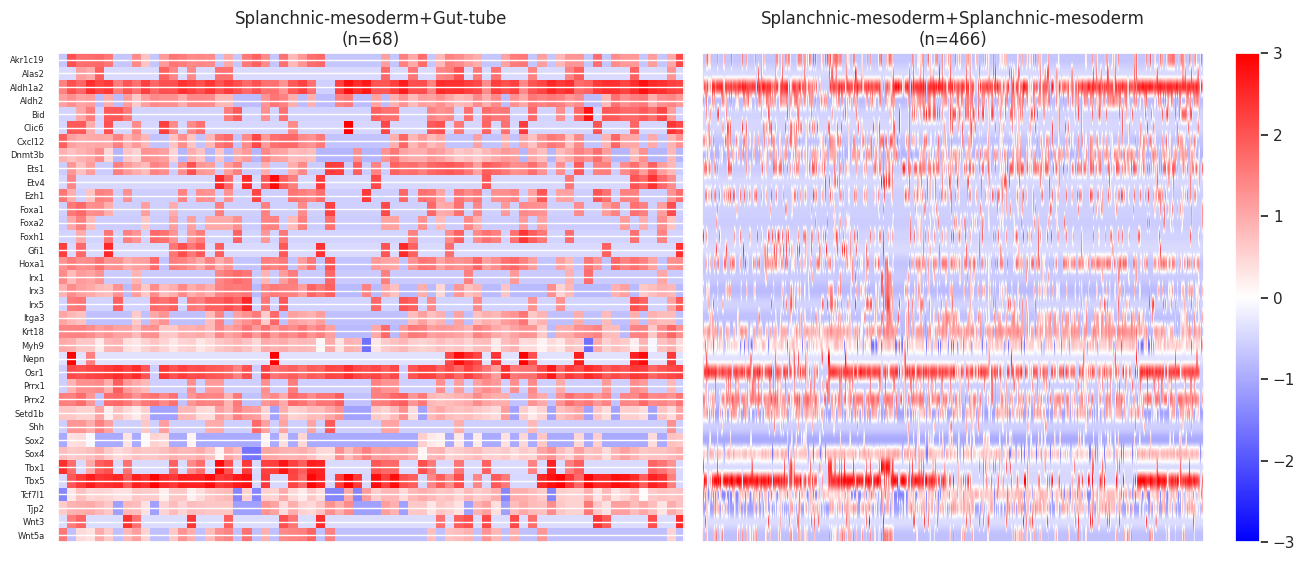

neighbor-dependent gene expression analysis:  17%|▏| 6/36 [00:11<01:01,  2.05s/i/home/sclab/miniconda3/envs/cellneighborex/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:1131: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  log_data_zvalue = (log_data_total - mean_values[:, np.newaxis]) / std_values[:, np.newaxis]


6


neighbor-dependent gene expression analysis:  19%|▏| 7/36 [00:11<00:44,  1.53s/i/home/sclab/miniconda3/envs/cellneighborex/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:1131: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  log_data_zvalue = (log_data_total - mean_values[:, np.newaxis]) / std_values[:, np.newaxis]


7


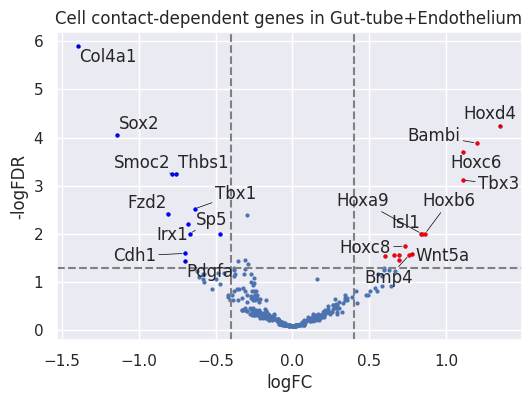

/home/sclab/miniconda3/envs/cellneighborex/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:660: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(a, fontsize=12)  # Sets the y-axis tick labels with fontsize 12


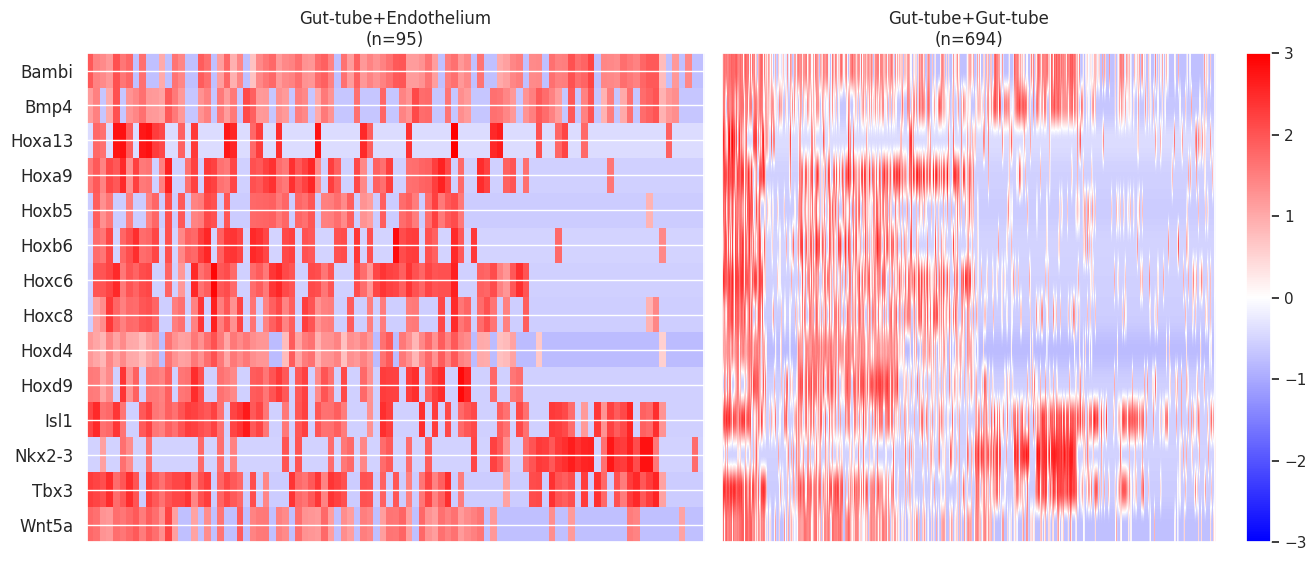

neighbor-dependent gene expression analysis:  22%|▏| 8/36 [00:14<00:55,  1.98s/i/home/sclab/miniconda3/envs/cellneighborex/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:1131: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  log_data_zvalue = (log_data_total - mean_values[:, np.newaxis]) / std_values[:, np.newaxis]


8


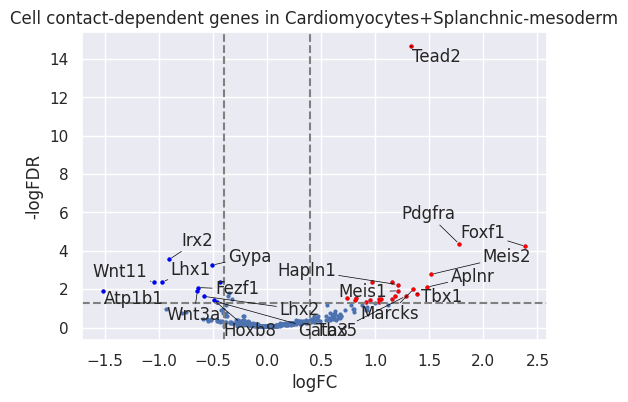

/home/sclab/miniconda3/envs/cellneighborex/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:660: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(a, fontsize=12)  # Sets the y-axis tick labels with fontsize 12


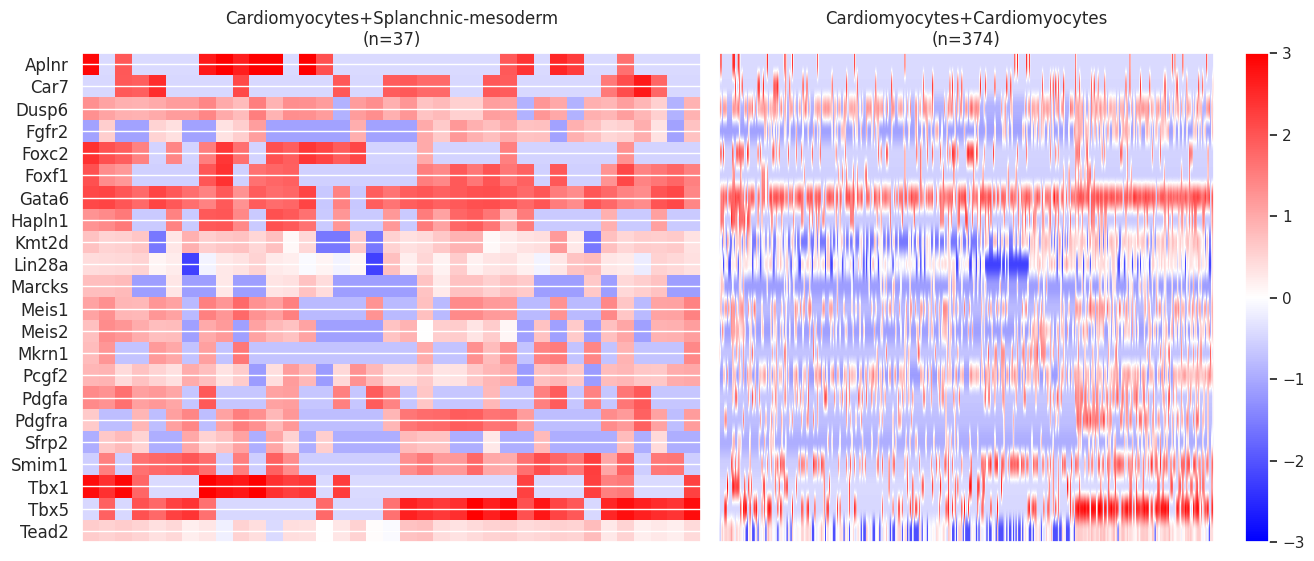

neighbor-dependent gene expression analysis:  25%|▎| 9/36 [00:20<01:26,  3.20s/i/home/sclab/miniconda3/envs/cellneighborex/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:1131: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  log_data_zvalue = (log_data_total - mean_values[:, np.newaxis]) / std_values[:, np.newaxis]


9


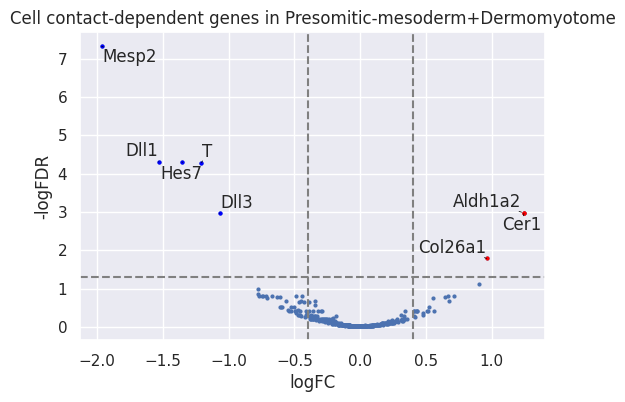

/home/sclab/miniconda3/envs/cellneighborex/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:660: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(a, fontsize=12)  # Sets the y-axis tick labels with fontsize 12


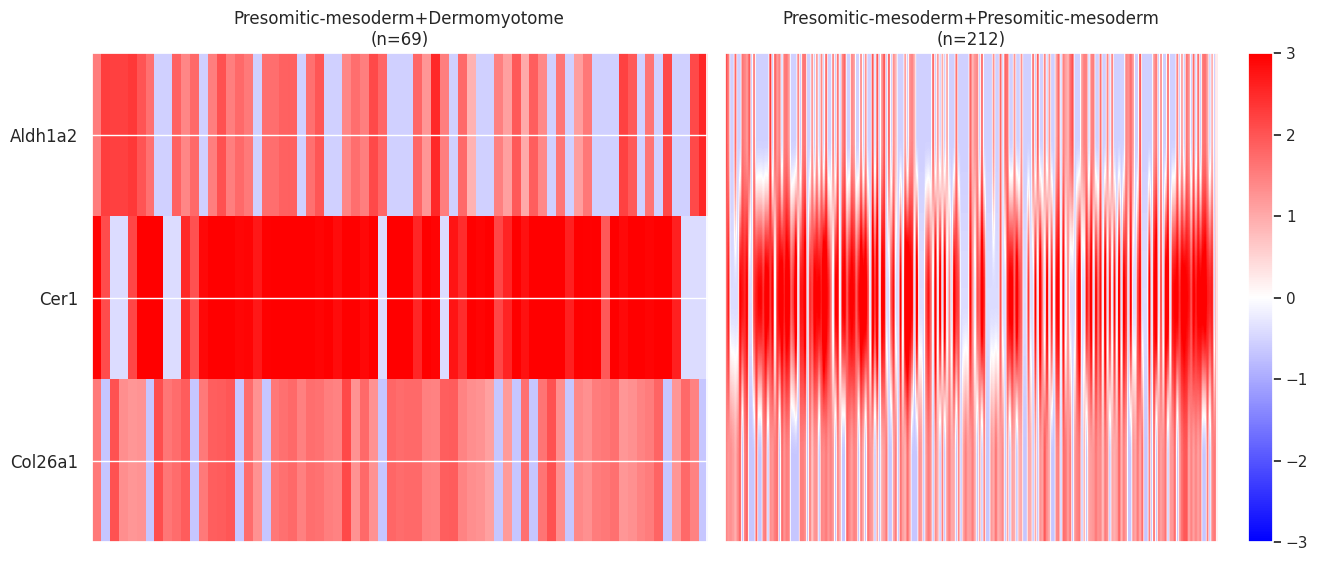

neighbor-dependent gene expression analysis:  28%|▎| 10/36 [00:21<01:08,  2.65s//home/sclab/miniconda3/envs/cellneighborex/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:1131: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  log_data_zvalue = (log_data_total - mean_values[:, np.newaxis]) / std_values[:, np.newaxis]


10


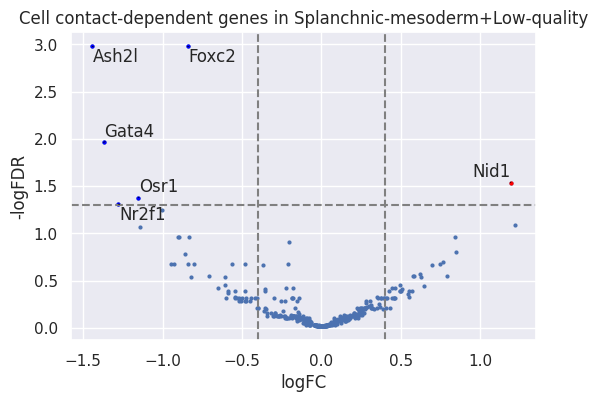

/home/sclab/miniconda3/envs/cellneighborex/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:660: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(a, fontsize=12)  # Sets the y-axis tick labels with fontsize 12


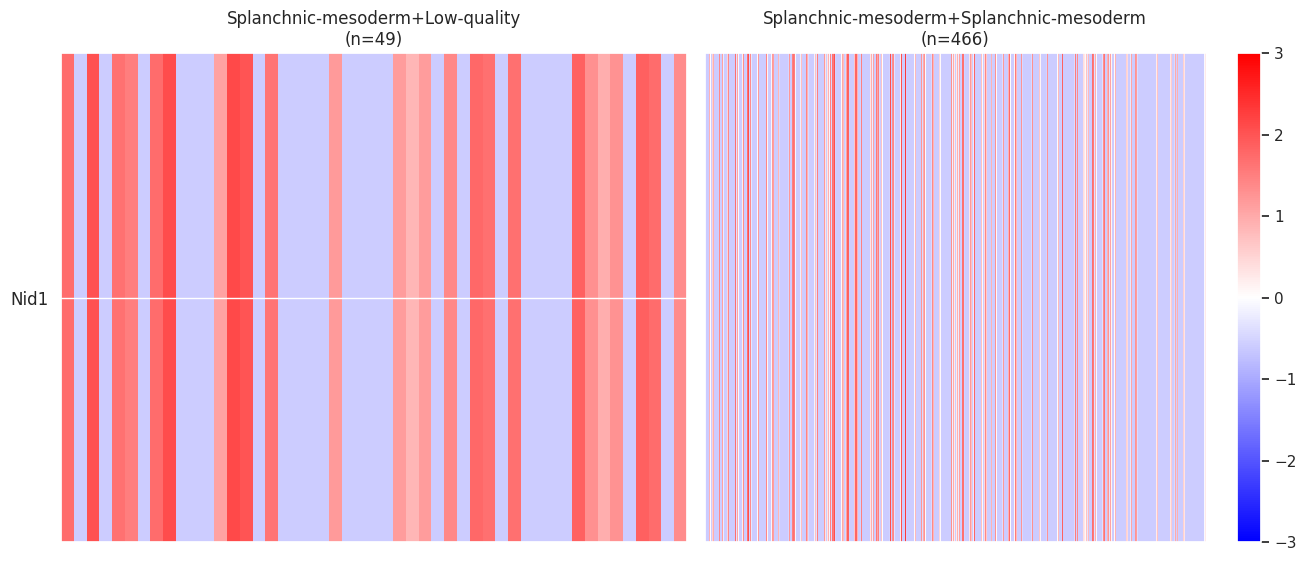

neighbor-dependent gene expression analysis:  31%|▎| 11/36 [00:23<00:56,  2.24s//home/sclab/miniconda3/envs/cellneighborex/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:1131: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  log_data_zvalue = (log_data_total - mean_values[:, np.newaxis]) / std_values[:, np.newaxis]


11


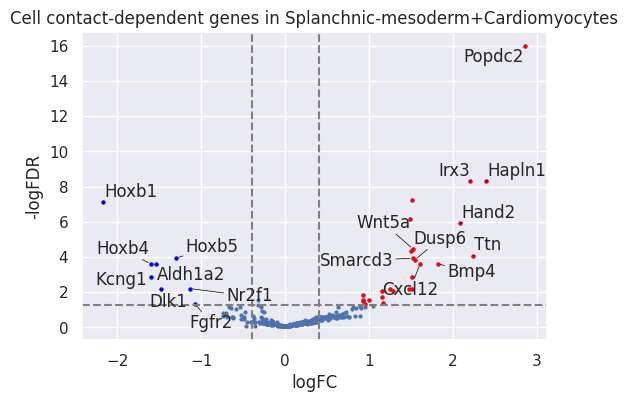

/home/sclab/miniconda3/envs/cellneighborex/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:660: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(a, fontsize=12)  # Sets the y-axis tick labels with fontsize 12


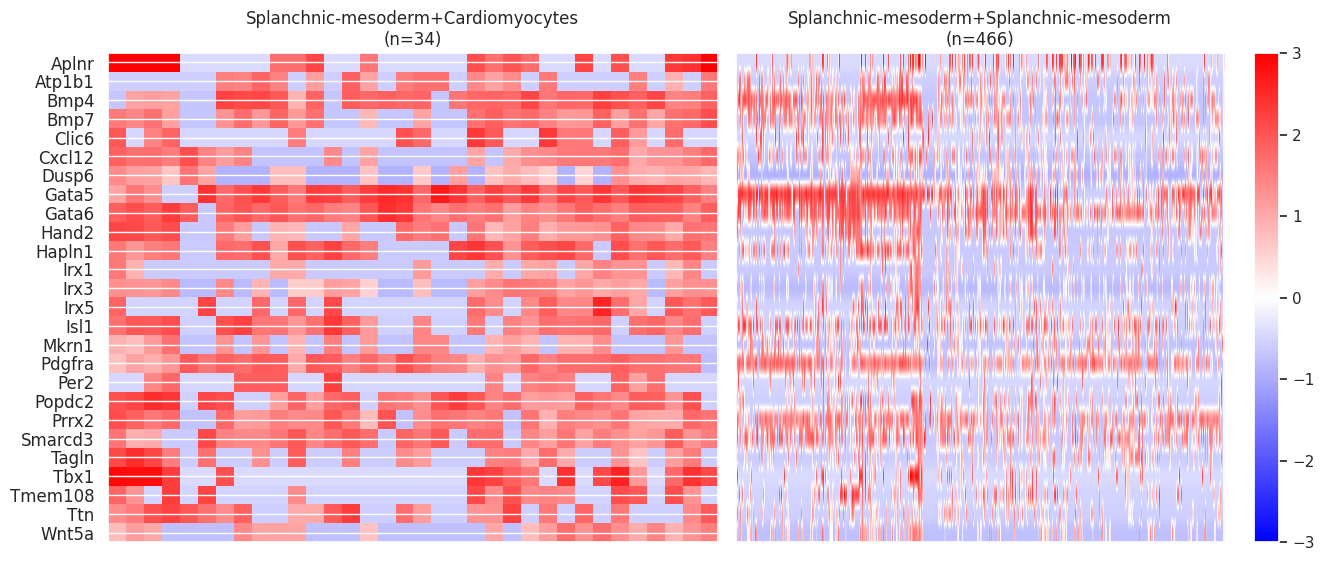

neighbor-dependent gene expression analysis:  33%|▎| 12/36 [00:25<00:52,  2.20s//home/sclab/miniconda3/envs/cellneighborex/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:1131: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  log_data_zvalue = (log_data_total - mean_values[:, np.newaxis]) / std_values[:, np.newaxis]


12


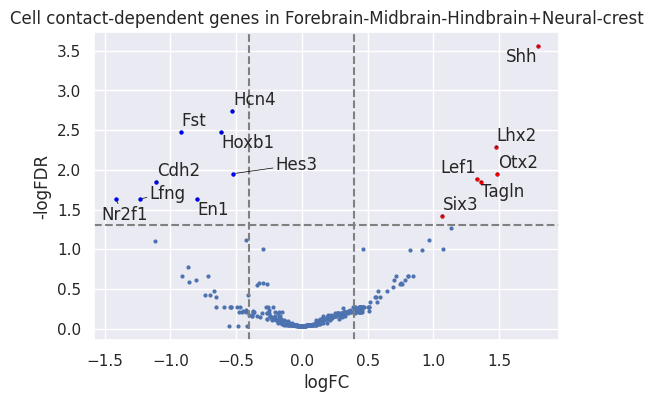

/home/sclab/miniconda3/envs/cellneighborex/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:660: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(a, fontsize=12)  # Sets the y-axis tick labels with fontsize 12


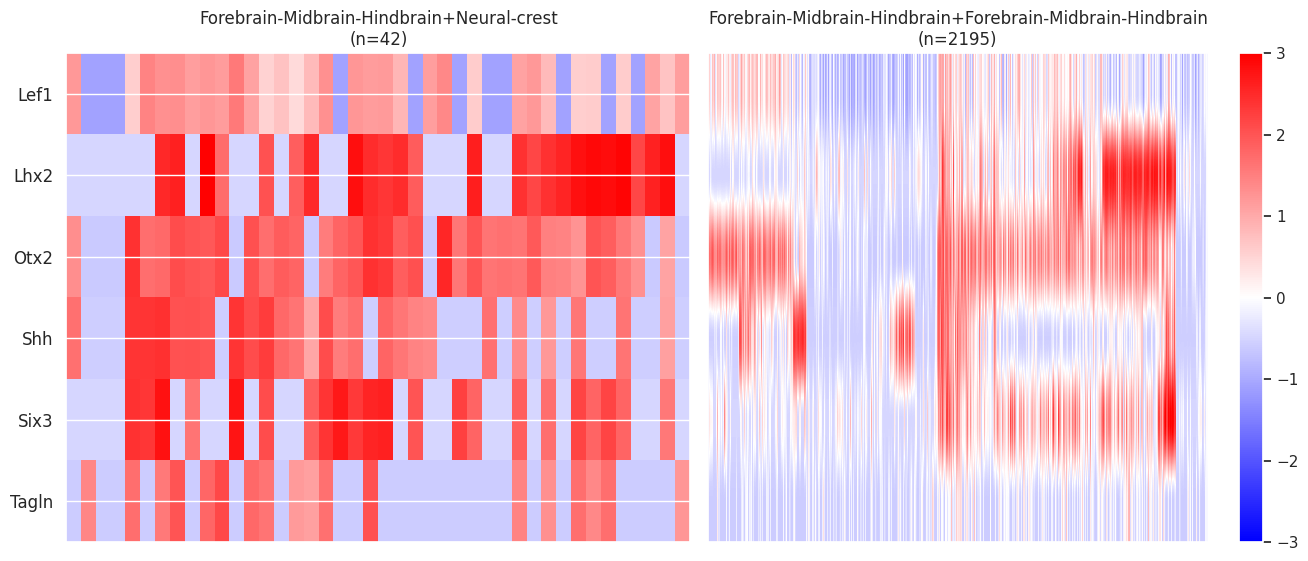

neighbor-dependent gene expression analysis:  36%|▎| 13/36 [00:27<00:48,  2.11s//home/sclab/miniconda3/envs/cellneighborex/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:1131: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  log_data_zvalue = (log_data_total - mean_values[:, np.newaxis]) / std_values[:, np.newaxis]


13


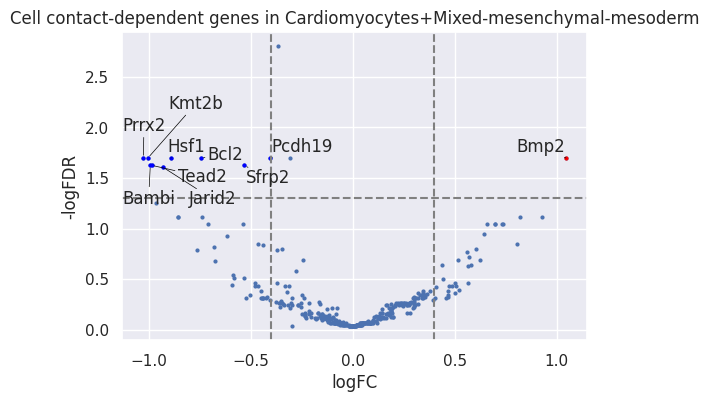

/home/sclab/miniconda3/envs/cellneighborex/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:660: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(a, fontsize=12)  # Sets the y-axis tick labels with fontsize 12


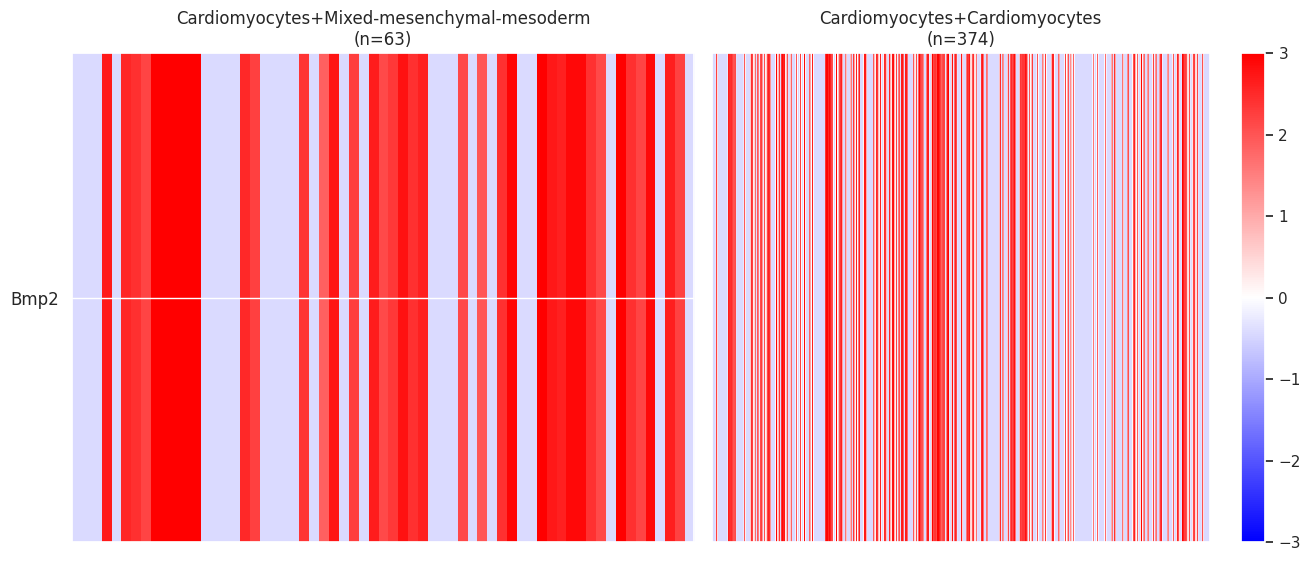

neighbor-dependent gene expression analysis:  39%|▍| 14/36 [00:30<00:52,  2.37s//home/sclab/miniconda3/envs/cellneighborex/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:1131: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  log_data_zvalue = (log_data_total - mean_values[:, np.newaxis]) / std_values[:, np.newaxis]


14


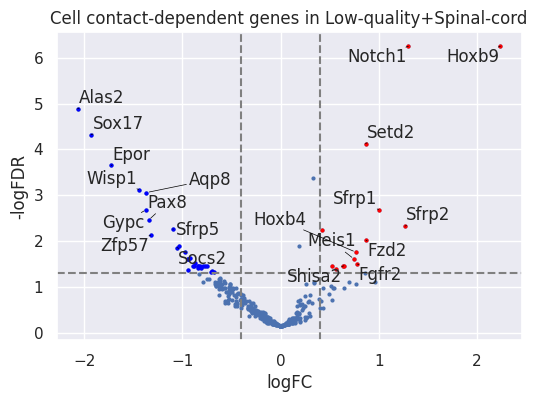

/home/sclab/miniconda3/envs/cellneighborex/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:660: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(a, fontsize=12)  # Sets the y-axis tick labels with fontsize 12


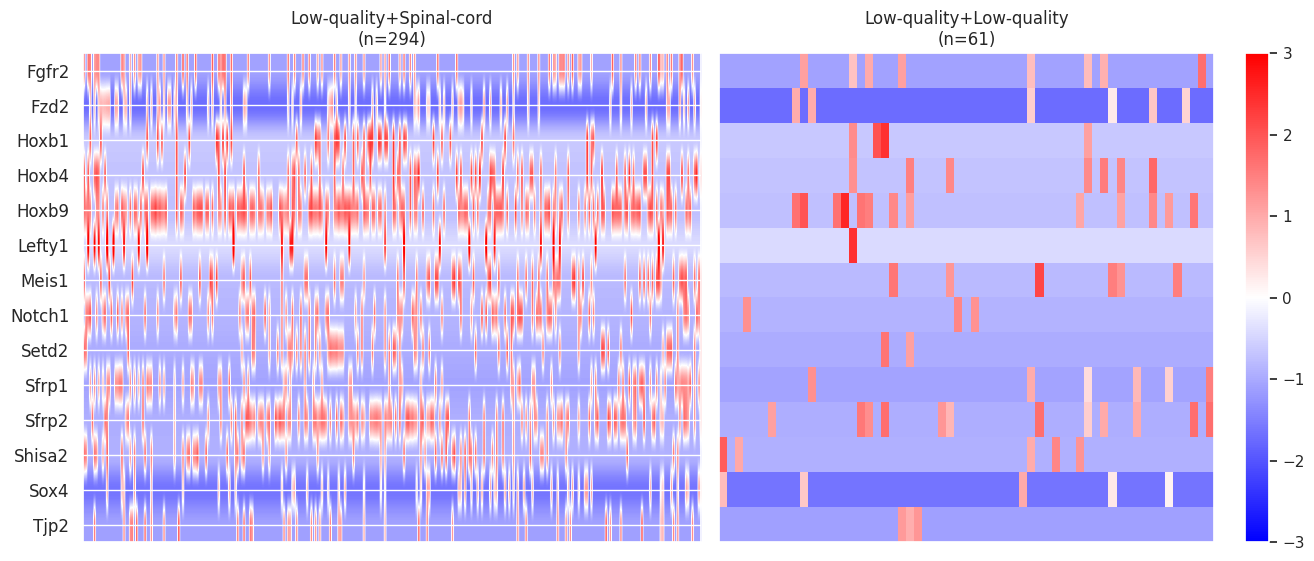

neighbor-dependent gene expression analysis:  42%|▍| 15/36 [00:32<00:48,  2.33s//home/sclab/miniconda3/envs/cellneighborex/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:1131: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  log_data_zvalue = (log_data_total - mean_values[:, np.newaxis]) / std_values[:, np.newaxis]


15


neighbor-dependent gene expression analysis:  44%|▍| 16/36 [00:32<00:35,  1.76s//home/sclab/miniconda3/envs/cellneighborex/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:1131: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  log_data_zvalue = (log_data_total - mean_values[:, np.newaxis]) / std_values[:, np.newaxis]


16


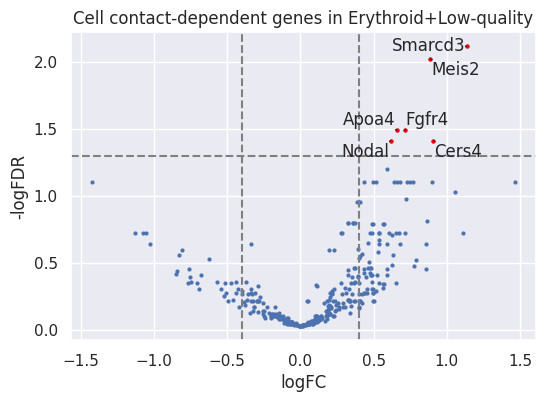

/home/sclab/miniconda3/envs/cellneighborex/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:660: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(a, fontsize=12)  # Sets the y-axis tick labels with fontsize 12


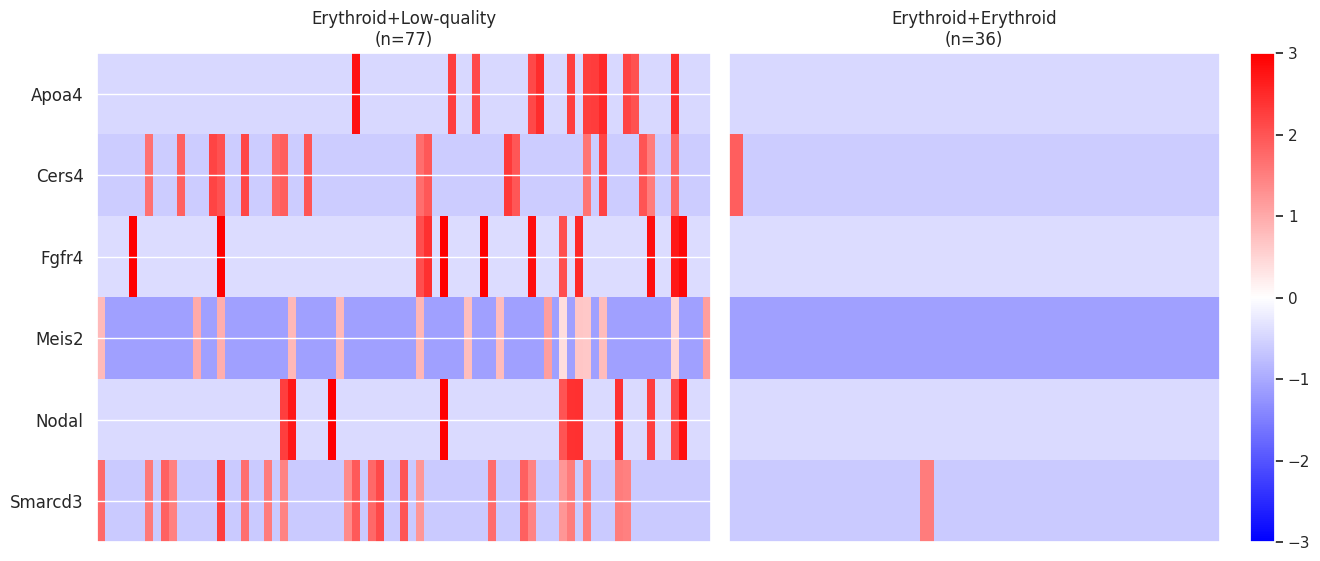

neighbor-dependent gene expression analysis:  47%|▍| 17/36 [00:34<00:32,  1.71s//home/sclab/miniconda3/envs/cellneighborex/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:1131: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  log_data_zvalue = (log_data_total - mean_values[:, np.newaxis]) / std_values[:, np.newaxis]


17


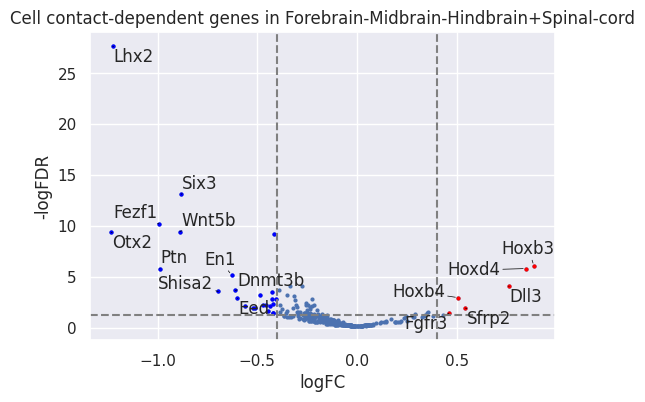

/home/sclab/miniconda3/envs/cellneighborex/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:660: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(a, fontsize=12)  # Sets the y-axis tick labels with fontsize 12


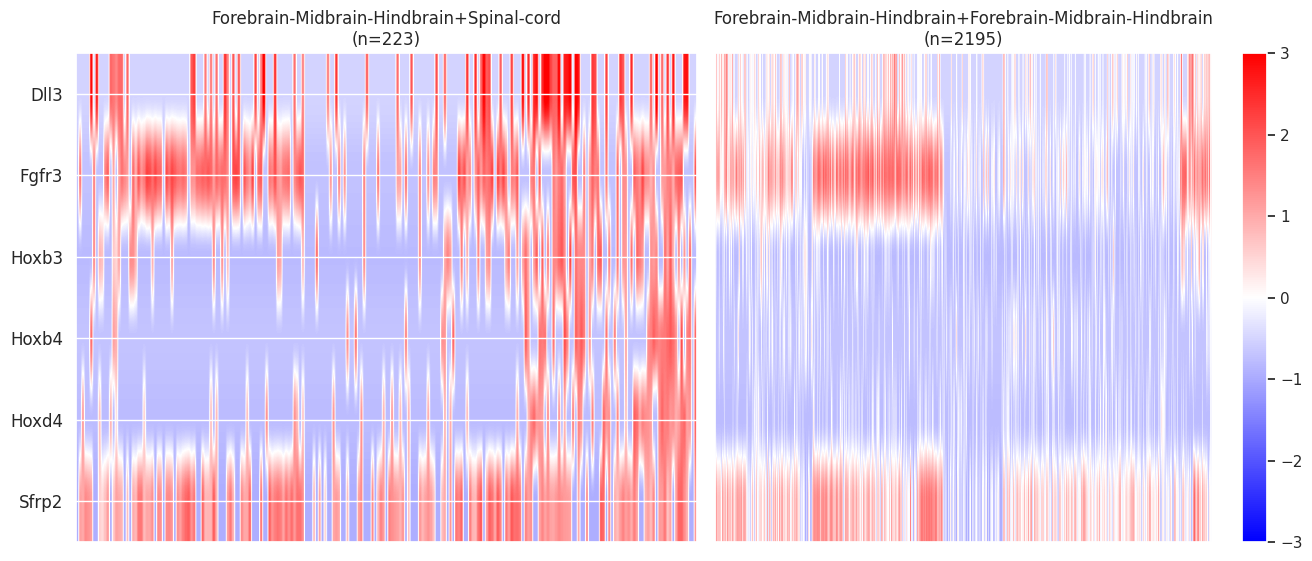

neighbor-dependent gene expression analysis:  50%|▌| 18/36 [00:36<00:32,  1.79s//home/sclab/miniconda3/envs/cellneighborex/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:1131: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  log_data_zvalue = (log_data_total - mean_values[:, np.newaxis]) / std_values[:, np.newaxis]


18


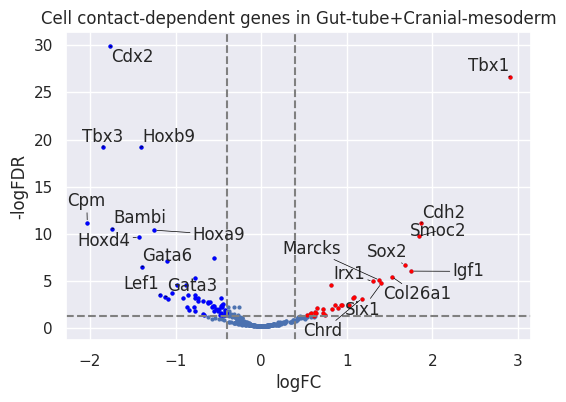

/home/sclab/miniconda3/envs/cellneighborex/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:660: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(a, fontsize=12)  # Sets the y-axis tick labels with fontsize 12


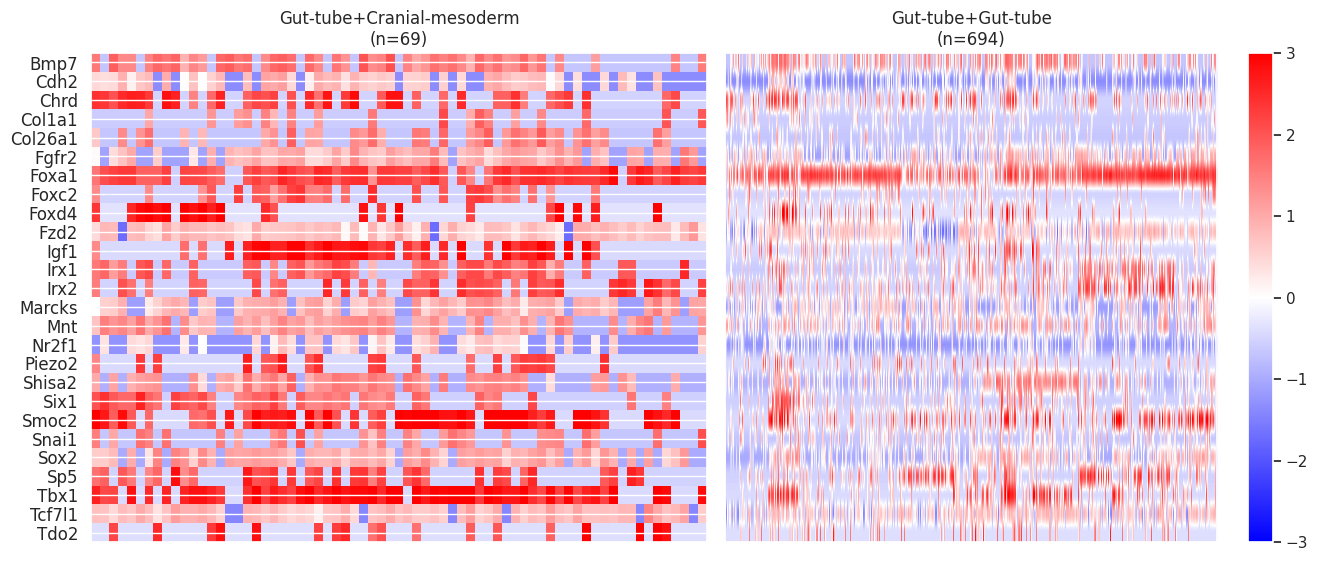

neighbor-dependent gene expression analysis:  53%|▌| 19/36 [00:40<00:42,  2.50s//home/sclab/miniconda3/envs/cellneighborex/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:1131: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  log_data_zvalue = (log_data_total - mean_values[:, np.newaxis]) / std_values[:, np.newaxis]


19


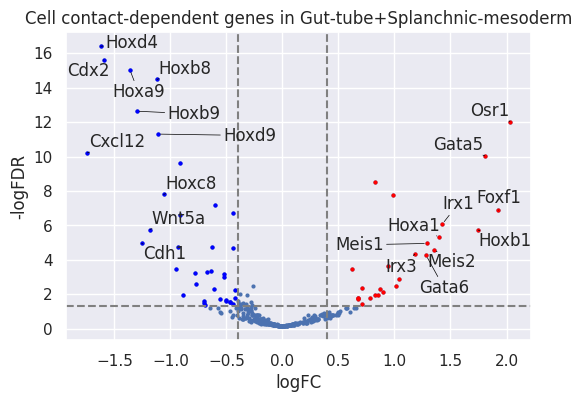

/home/sclab/miniconda3/envs/cellneighborex/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:660: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(a, fontsize=12)  # Sets the y-axis tick labels with fontsize 12


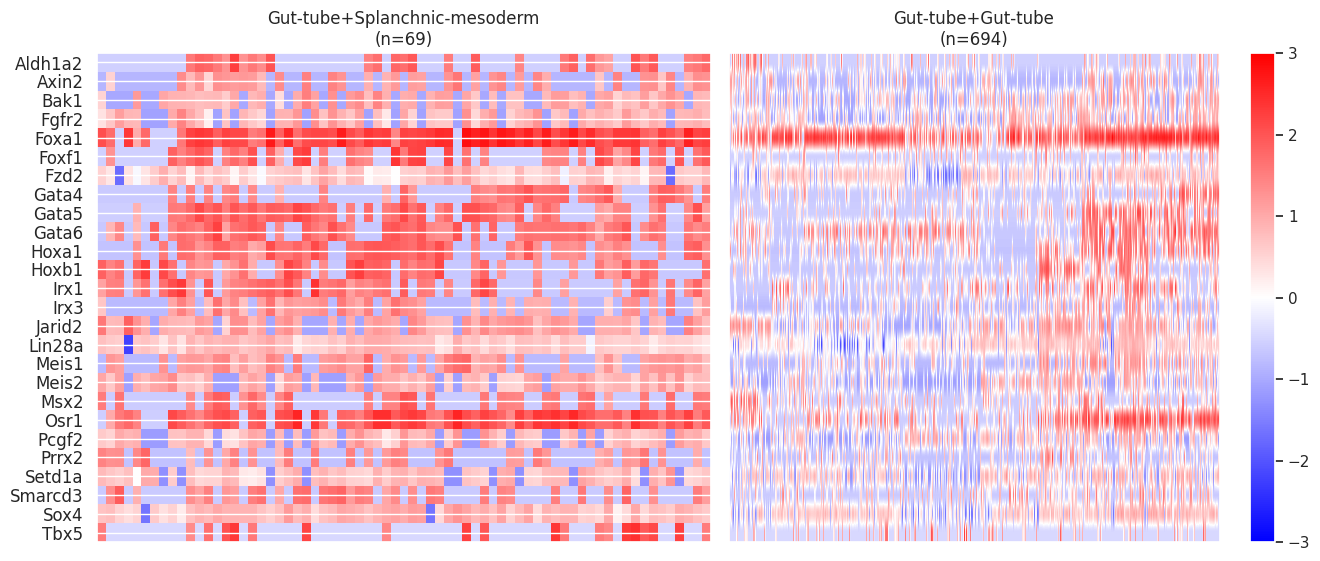

neighbor-dependent gene expression analysis:  56%|▌| 20/36 [00:44<00:48,  3.01s//home/sclab/miniconda3/envs/cellneighborex/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:1131: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  log_data_zvalue = (log_data_total - mean_values[:, np.newaxis]) / std_values[:, np.newaxis]


20


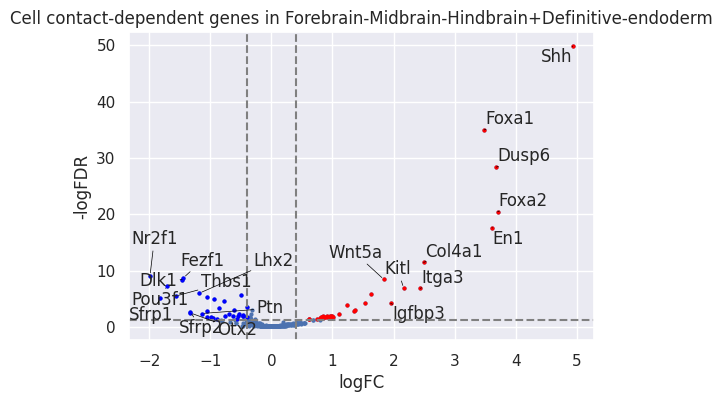

/home/sclab/miniconda3/envs/cellneighborex/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:660: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(a, fontsize=12)  # Sets the y-axis tick labels with fontsize 12


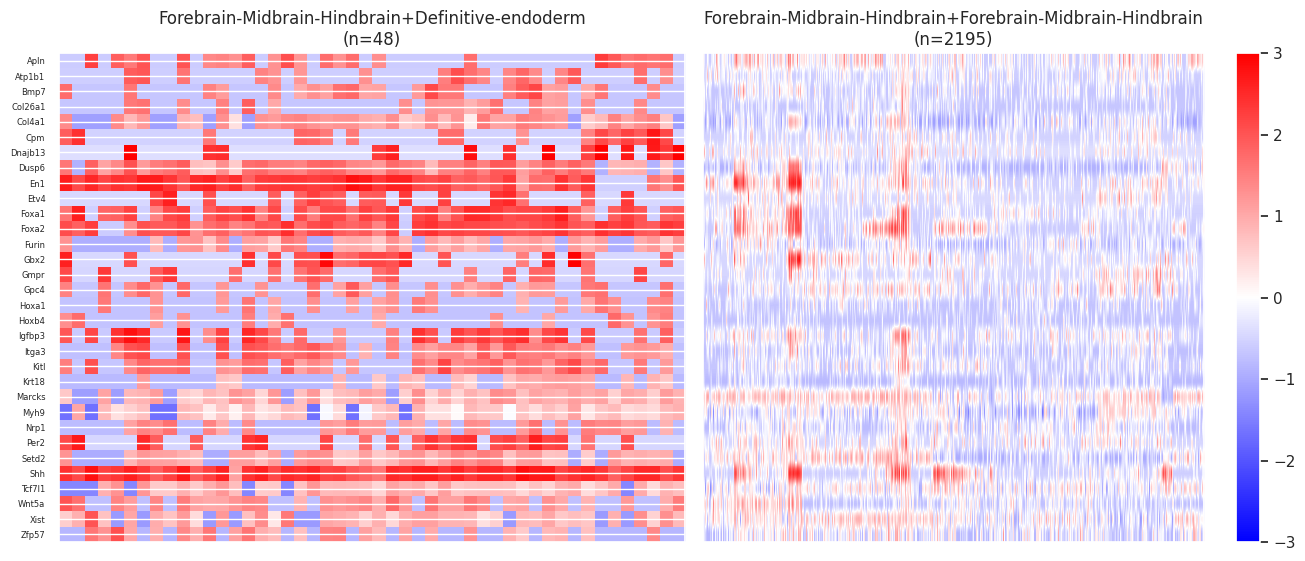

neighbor-dependent gene expression analysis:  58%|▌| 21/36 [00:47<00:44,  2.99s//home/sclab/miniconda3/envs/cellneighborex/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:1131: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  log_data_zvalue = (log_data_total - mean_values[:, np.newaxis]) / std_values[:, np.newaxis]


21


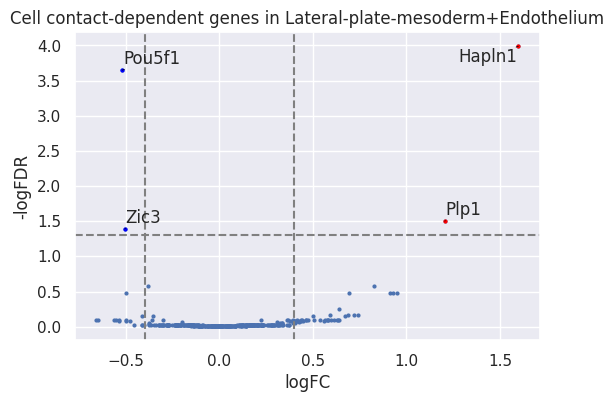

/home/sclab/miniconda3/envs/cellneighborex/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:660: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(a, fontsize=12)  # Sets the y-axis tick labels with fontsize 12


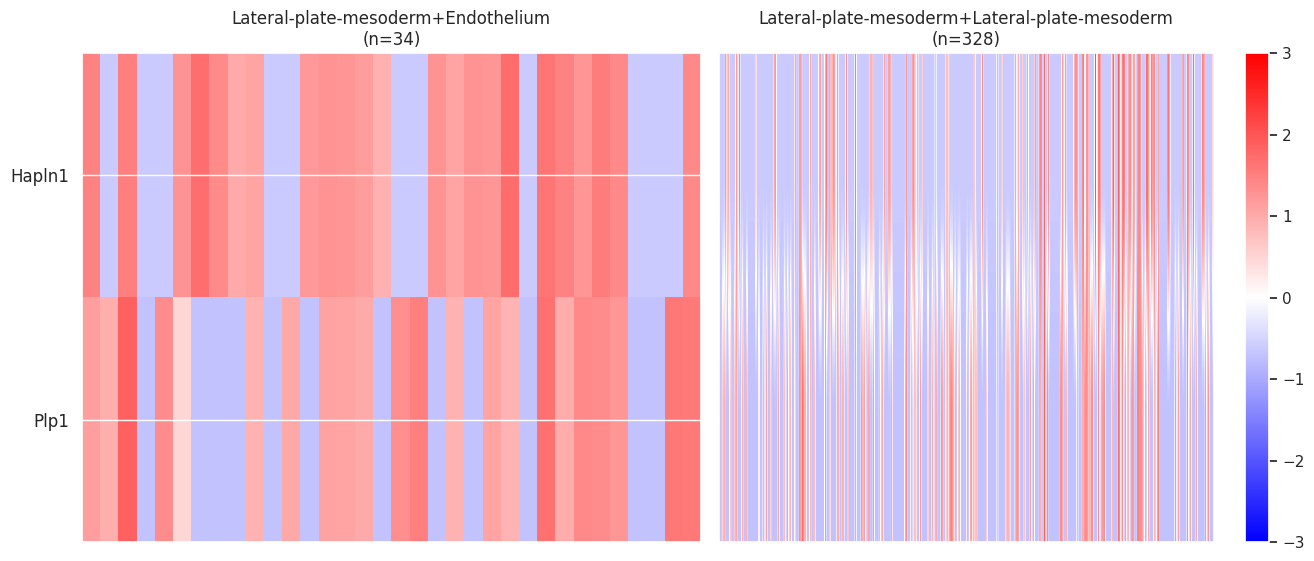

neighbor-dependent gene expression analysis:  61%|▌| 22/36 [00:49<00:34,  2.47s//home/sclab/miniconda3/envs/cellneighborex/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:1131: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  log_data_zvalue = (log_data_total - mean_values[:, np.newaxis]) / std_values[:, np.newaxis]


22


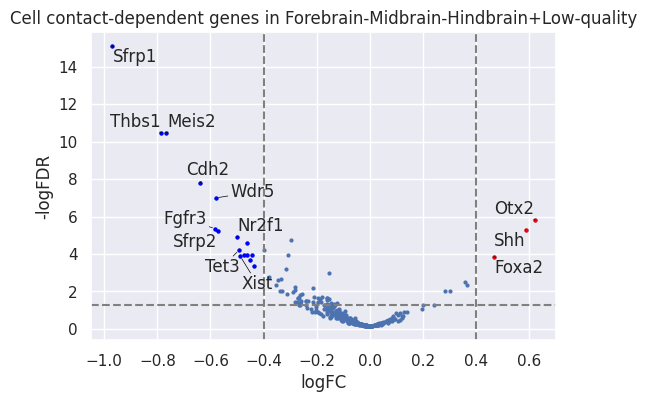

/home/sclab/miniconda3/envs/cellneighborex/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:660: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(a, fontsize=12)  # Sets the y-axis tick labels with fontsize 12


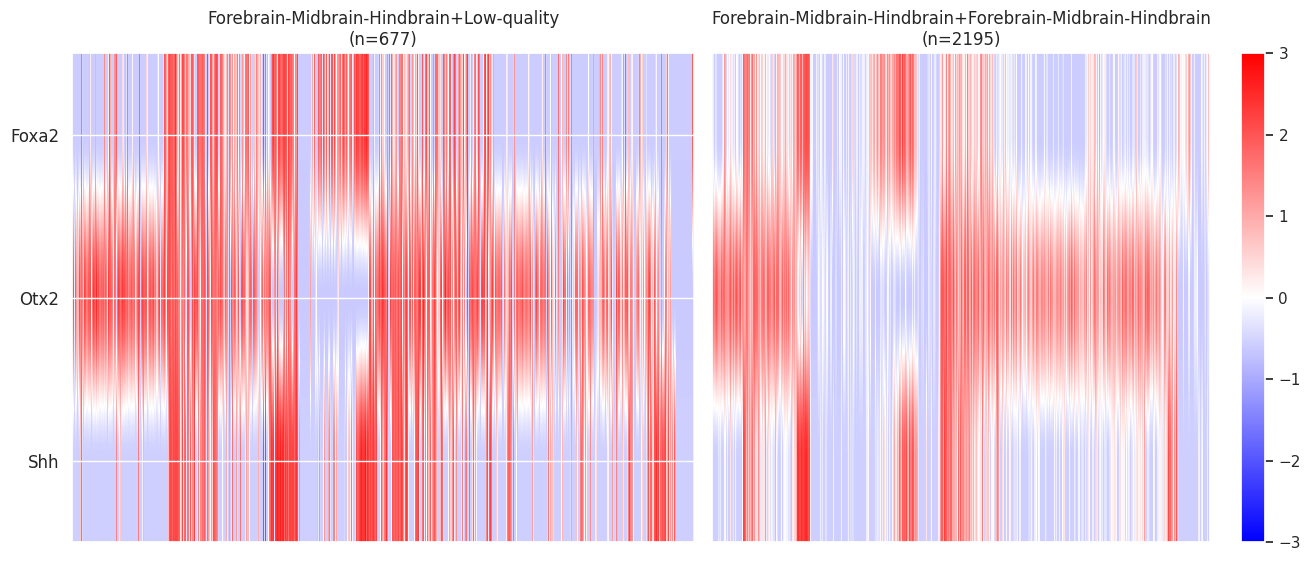

neighbor-dependent gene expression analysis:  64%|▋| 23/36 [00:51<00:30,  2.35s//home/sclab/miniconda3/envs/cellneighborex/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:1131: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  log_data_zvalue = (log_data_total - mean_values[:, np.newaxis]) / std_values[:, np.newaxis]


23


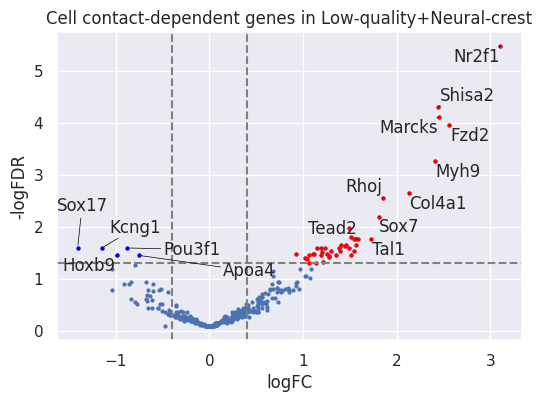

/home/sclab/miniconda3/envs/cellneighborex/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:660: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(a, fontsize=12)  # Sets the y-axis tick labels with fontsize 12


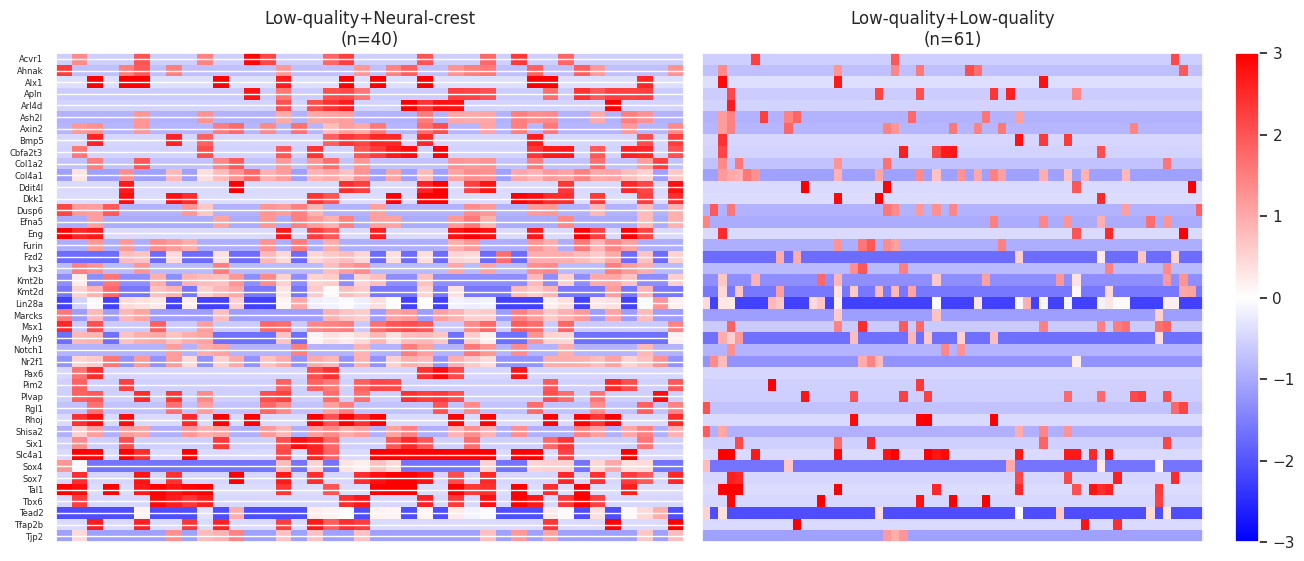

neighbor-dependent gene expression analysis:  67%|▋| 24/36 [00:53<00:27,  2.31s//home/sclab/miniconda3/envs/cellneighborex/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:1131: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  log_data_zvalue = (log_data_total - mean_values[:, np.newaxis]) / std_values[:, np.newaxis]


24


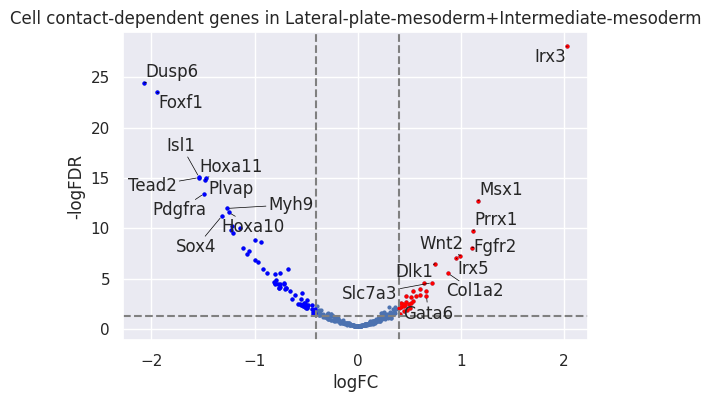

/home/sclab/miniconda3/envs/cellneighborex/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:660: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(a, fontsize=12)  # Sets the y-axis tick labels with fontsize 12


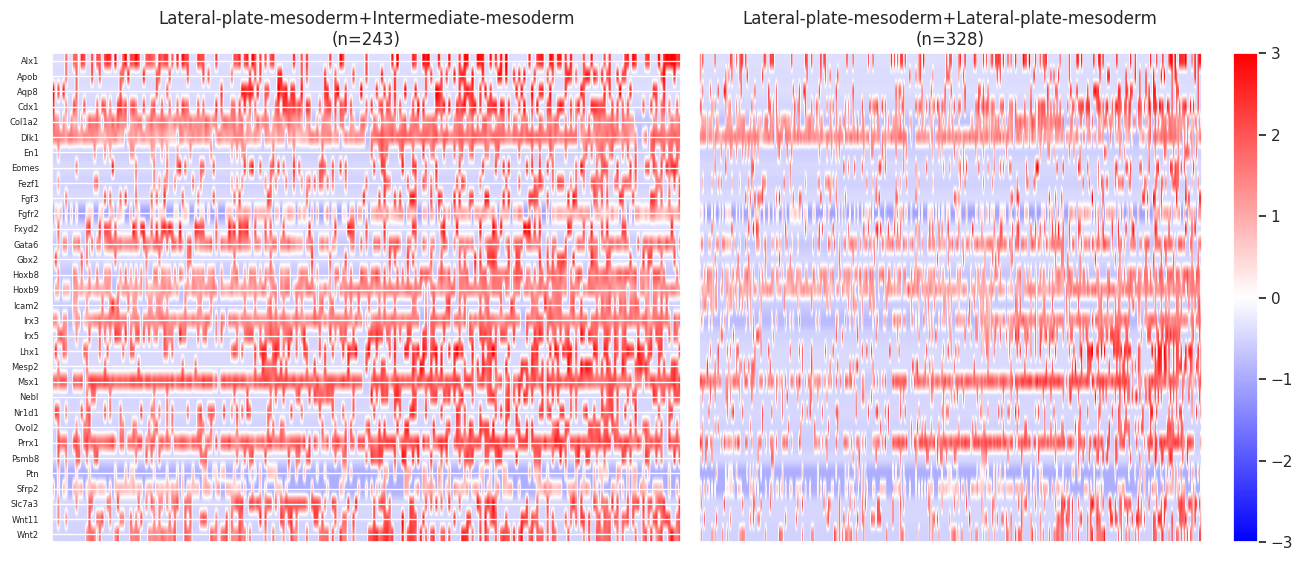

neighbor-dependent gene expression analysis:  69%|▋| 25/36 [00:55<00:25,  2.28s//home/sclab/miniconda3/envs/cellneighborex/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:1131: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  log_data_zvalue = (log_data_total - mean_values[:, np.newaxis]) / std_values[:, np.newaxis]


25


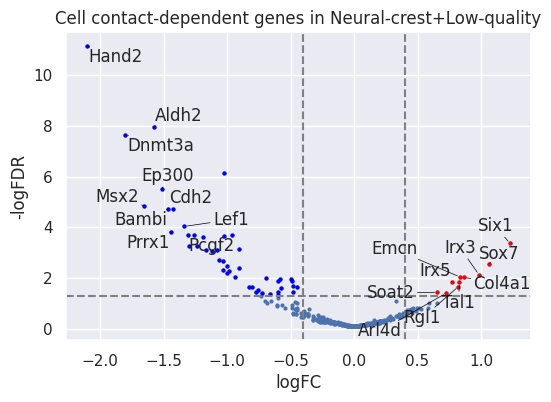

/home/sclab/miniconda3/envs/cellneighborex/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:660: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(a, fontsize=12)  # Sets the y-axis tick labels with fontsize 12


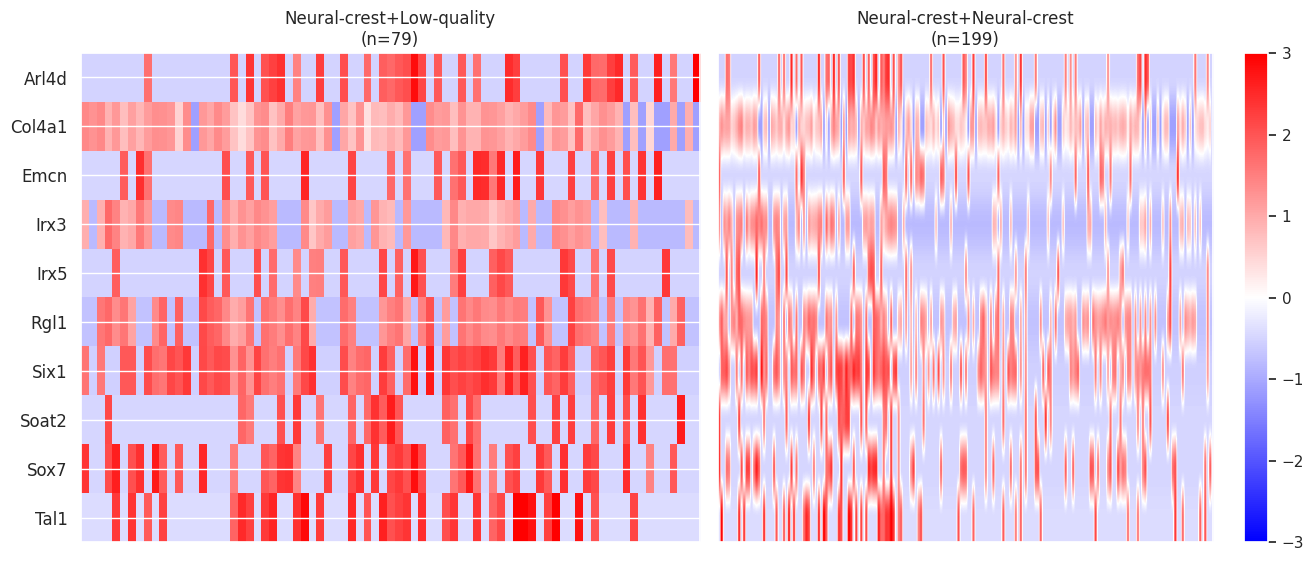

neighbor-dependent gene expression analysis:  72%|▋| 26/36 [00:58<00:24,  2.42s//home/sclab/miniconda3/envs/cellneighborex/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:1131: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  log_data_zvalue = (log_data_total - mean_values[:, np.newaxis]) / std_values[:, np.newaxis]


26


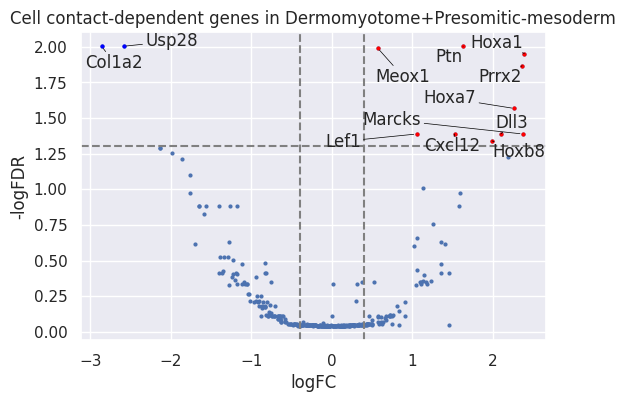

/home/sclab/miniconda3/envs/cellneighborex/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:660: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(a, fontsize=12)  # Sets the y-axis tick labels with fontsize 12


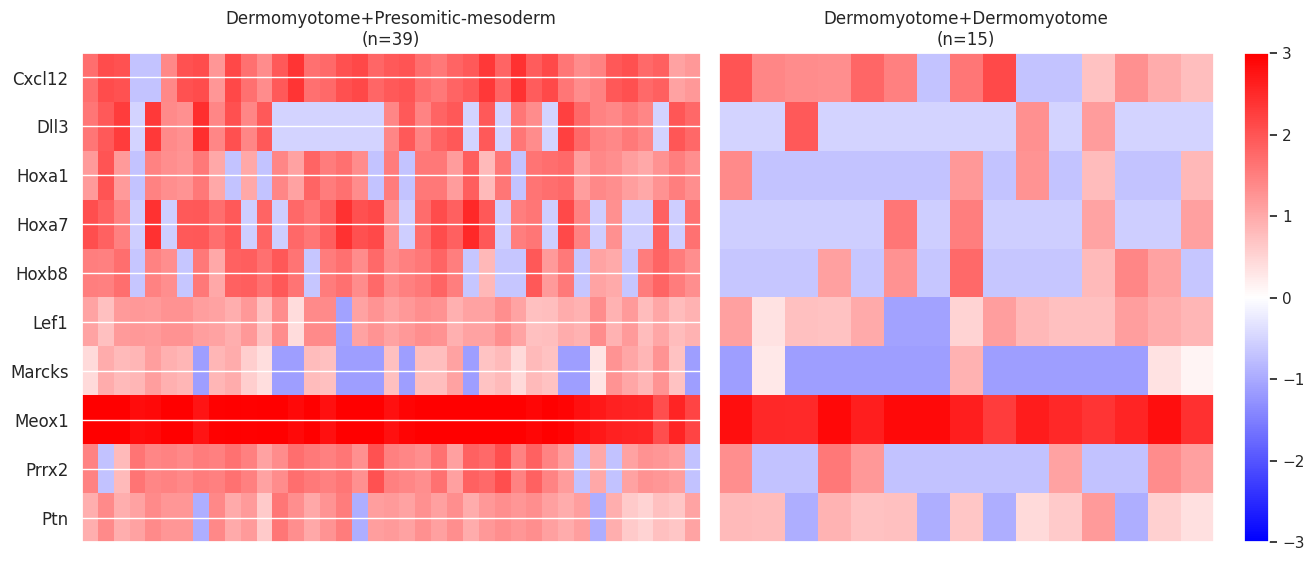

neighbor-dependent gene expression analysis:  75%|▊| 27/36 [01:00<00:21,  2.42s//home/sclab/miniconda3/envs/cellneighborex/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:1131: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  log_data_zvalue = (log_data_total - mean_values[:, np.newaxis]) / std_values[:, np.newaxis]


27


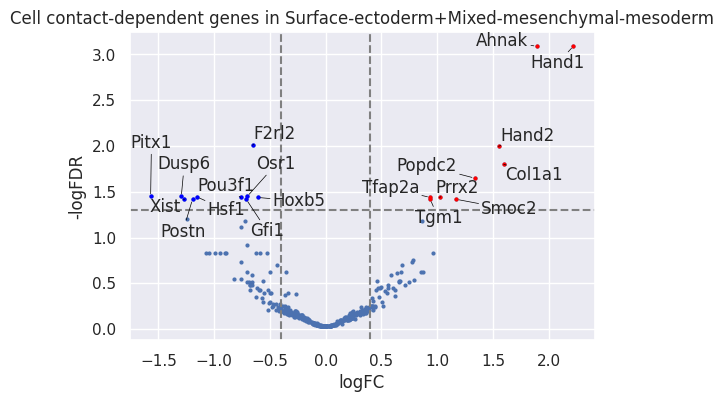

/home/sclab/miniconda3/envs/cellneighborex/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:660: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(a, fontsize=12)  # Sets the y-axis tick labels with fontsize 12


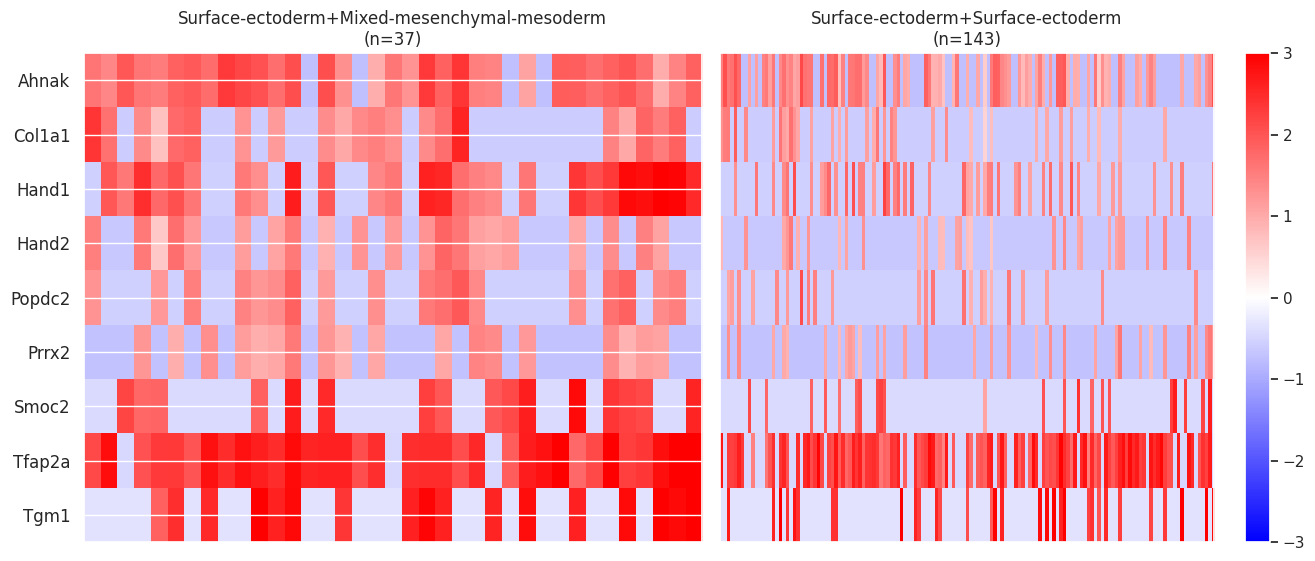

neighbor-dependent gene expression analysis:  78%|▊| 28/36 [01:05<00:25,  3.20s//home/sclab/miniconda3/envs/cellneighborex/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:1131: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  log_data_zvalue = (log_data_total - mean_values[:, np.newaxis]) / std_values[:, np.newaxis]


28


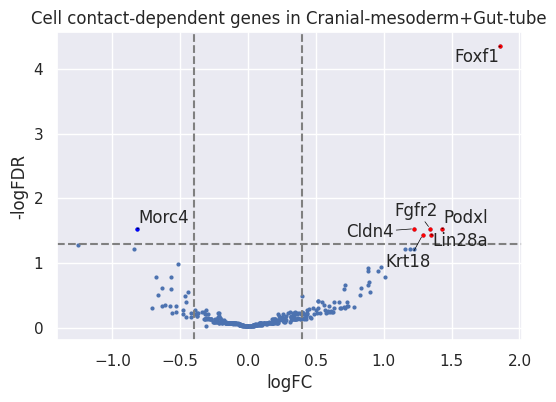

/home/sclab/miniconda3/envs/cellneighborex/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:660: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(a, fontsize=12)  # Sets the y-axis tick labels with fontsize 12


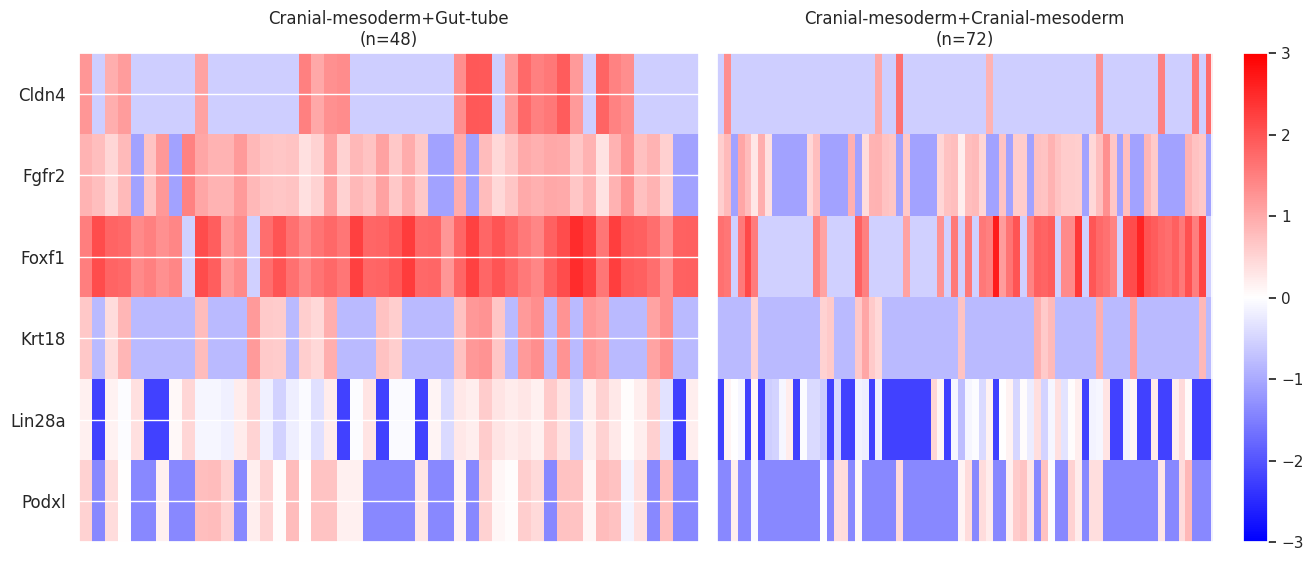

neighbor-dependent gene expression analysis:  81%|▊| 29/36 [01:07<00:18,  2.65s//home/sclab/miniconda3/envs/cellneighborex/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:1131: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  log_data_zvalue = (log_data_total - mean_values[:, np.newaxis]) / std_values[:, np.newaxis]


29


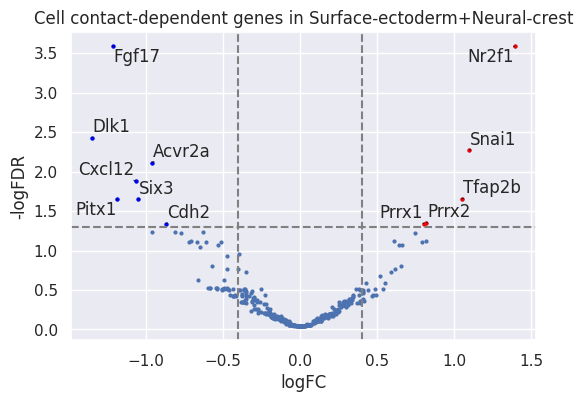

/home/sclab/miniconda3/envs/cellneighborex/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:660: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(a, fontsize=12)  # Sets the y-axis tick labels with fontsize 12


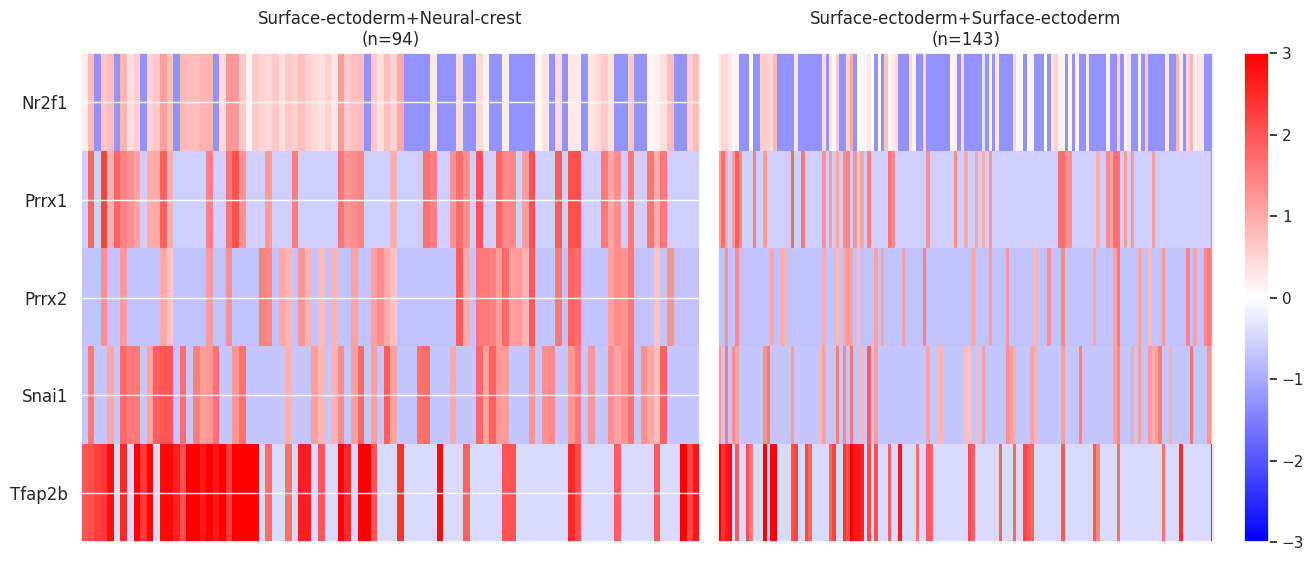

neighbor-dependent gene expression analysis:  83%|▊| 30/36 [01:08<00:13,  2.30s//home/sclab/miniconda3/envs/cellneighborex/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:1131: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  log_data_zvalue = (log_data_total - mean_values[:, np.newaxis]) / std_values[:, np.newaxis]


30


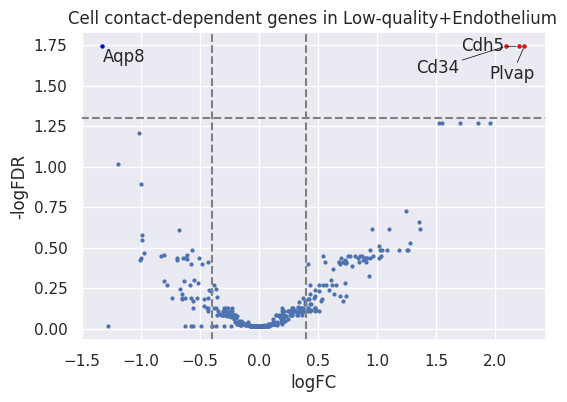

/home/sclab/miniconda3/envs/cellneighborex/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:660: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(a, fontsize=12)  # Sets the y-axis tick labels with fontsize 12


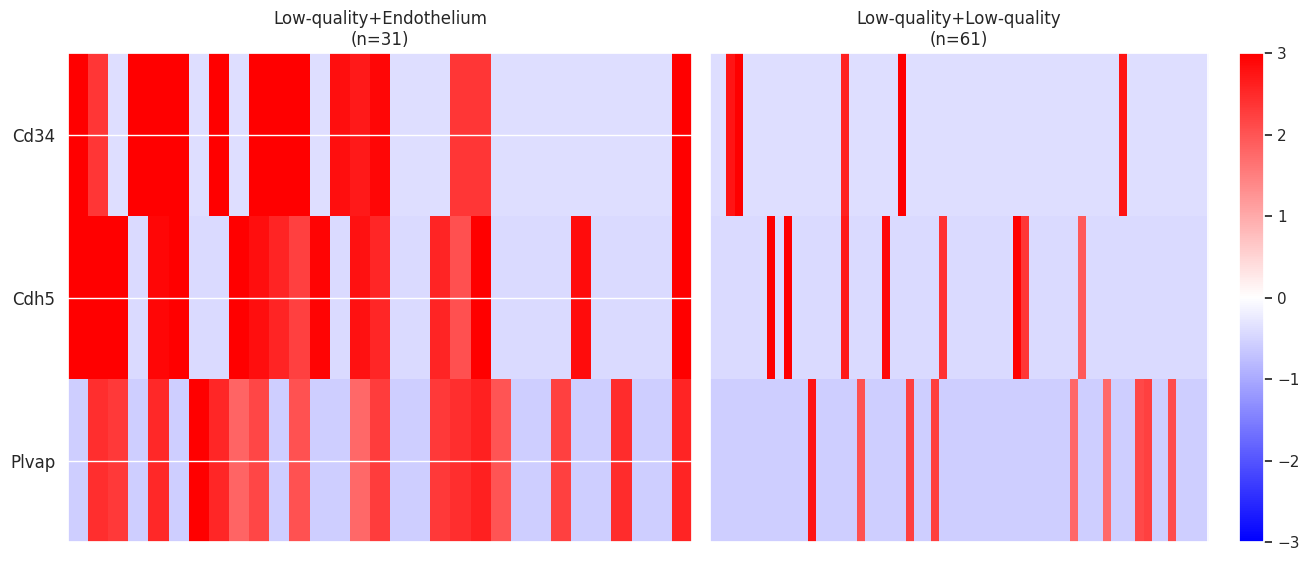

neighbor-dependent gene expression analysis:  86%|▊| 31/36 [01:10<00:10,  2.19s//home/sclab/miniconda3/envs/cellneighborex/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:1131: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  log_data_zvalue = (log_data_total - mean_values[:, np.newaxis]) / std_values[:, np.newaxis]


31


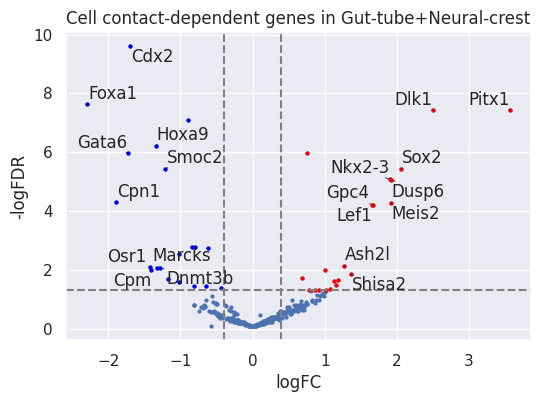

/home/sclab/miniconda3/envs/cellneighborex/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:660: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(a, fontsize=12)  # Sets the y-axis tick labels with fontsize 12


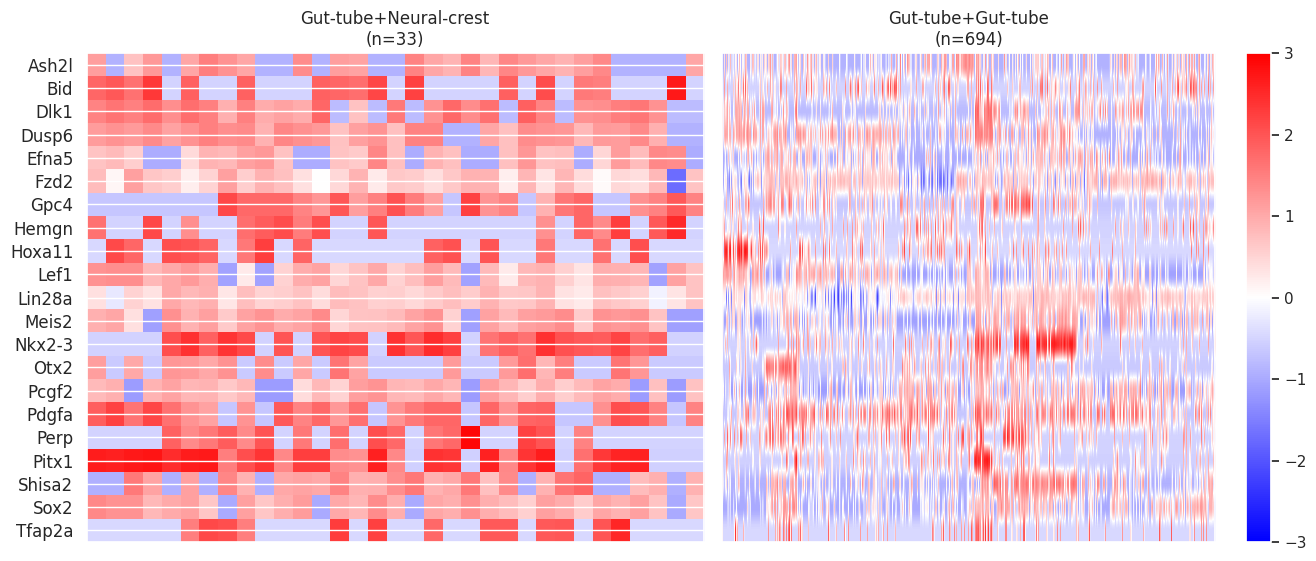

neighbor-dependent gene expression analysis:  89%|▉| 32/36 [01:12<00:08,  2.18s//home/sclab/miniconda3/envs/cellneighborex/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:1131: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  log_data_zvalue = (log_data_total - mean_values[:, np.newaxis]) / std_values[:, np.newaxis]


32


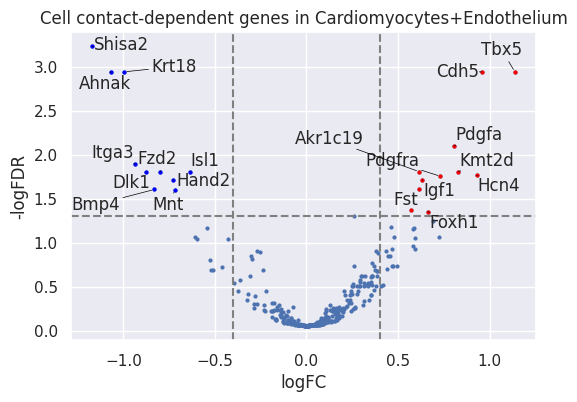

/home/sclab/miniconda3/envs/cellneighborex/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:660: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(a, fontsize=12)  # Sets the y-axis tick labels with fontsize 12


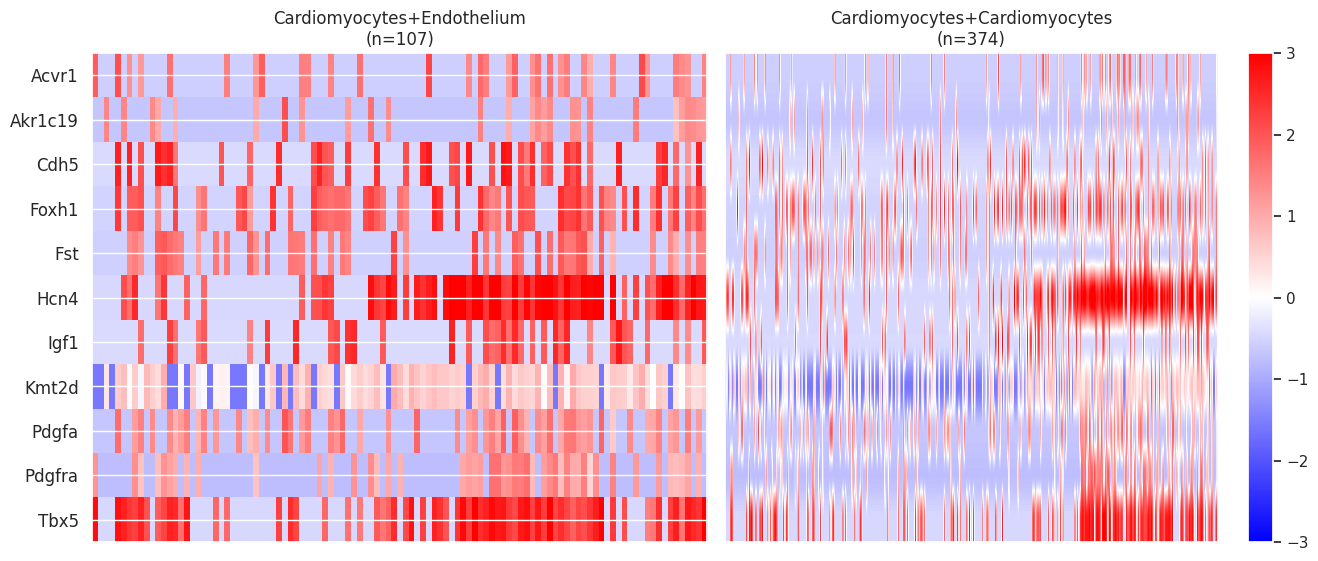

neighbor-dependent gene expression analysis:  92%|▉| 33/36 [01:16<00:08,  2.69s//home/sclab/miniconda3/envs/cellneighborex/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:1131: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  log_data_zvalue = (log_data_total - mean_values[:, np.newaxis]) / std_values[:, np.newaxis]


33


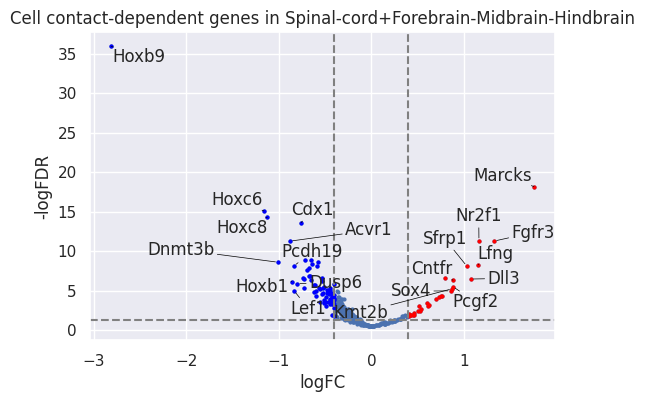

/home/sclab/miniconda3/envs/cellneighborex/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:660: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(a, fontsize=12)  # Sets the y-axis tick labels with fontsize 12


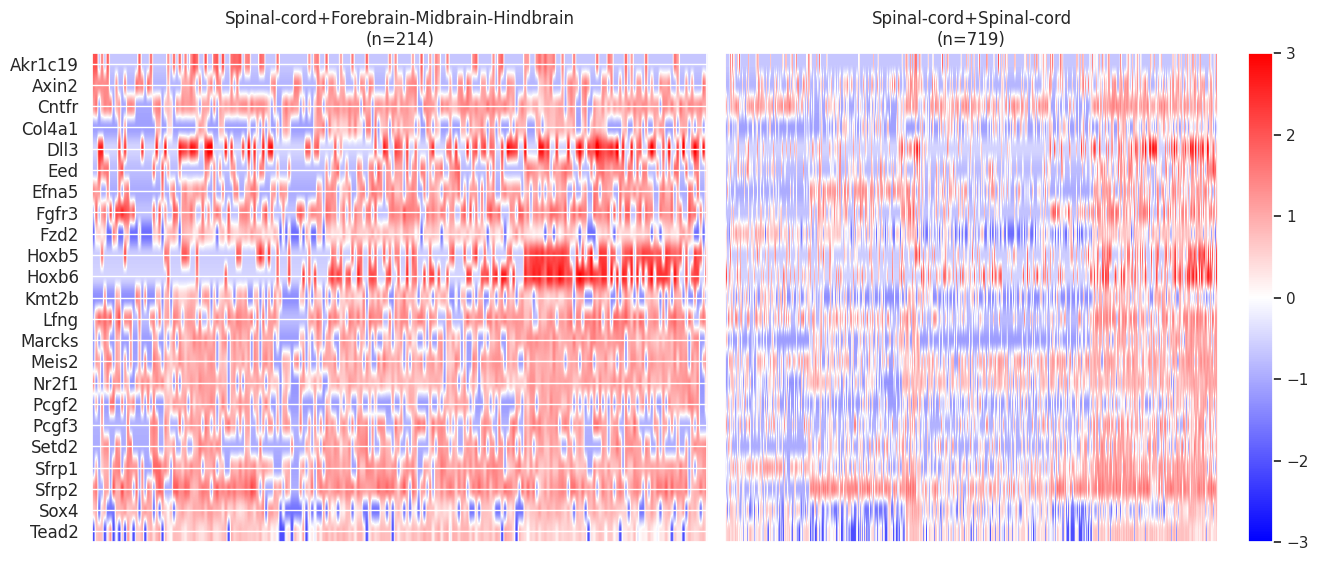

neighbor-dependent gene expression analysis:  94%|▉| 34/36 [01:19<00:05,  2.87s//home/sclab/miniconda3/envs/cellneighborex/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:1131: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  log_data_zvalue = (log_data_total - mean_values[:, np.newaxis]) / std_values[:, np.newaxis]
/home/sclab/miniconda3/envs/cellneighborex/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:1131: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  log_data_zvalue = (log_data_total - mean_values[:, np.newaxis]) / std_values[:, np.newaxis]


34
35


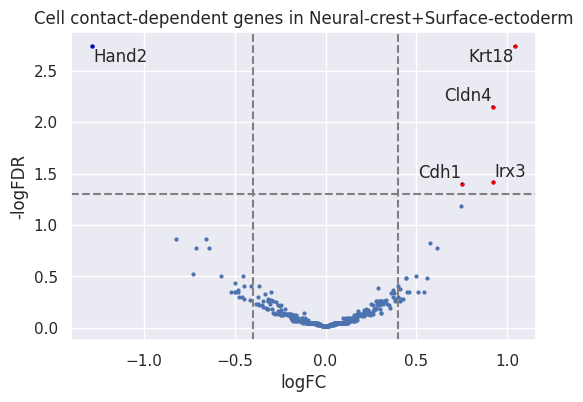

/home/sclab/miniconda3/envs/cellneighborex/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:660: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(a, fontsize=12)  # Sets the y-axis tick labels with fontsize 12


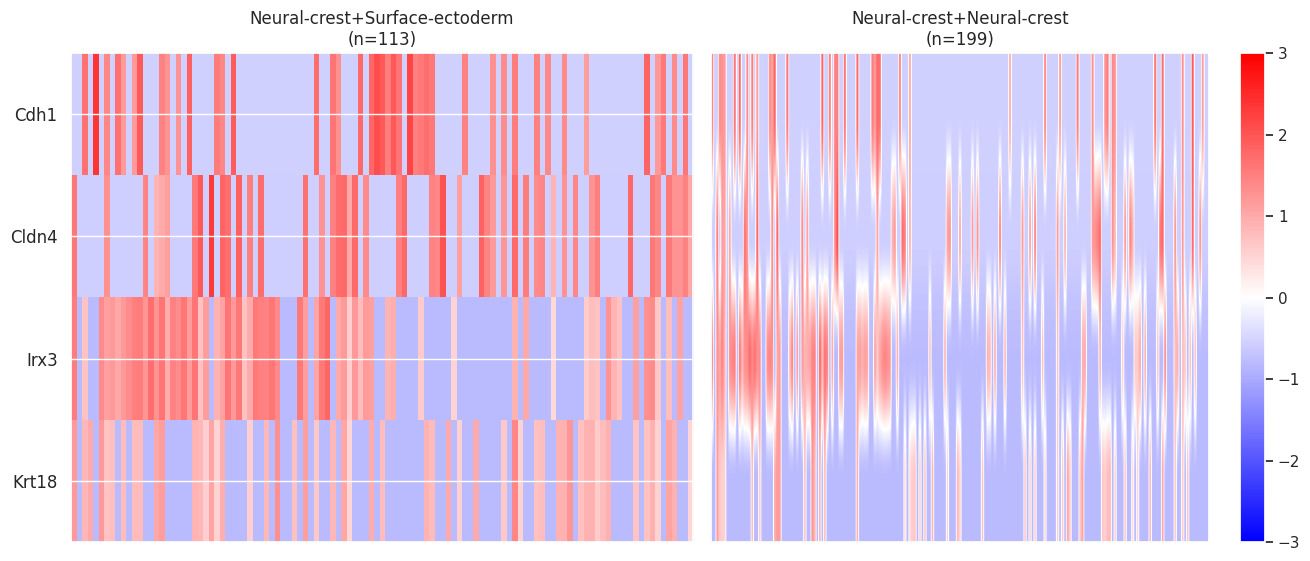

neighbor-dependent gene expression analysis: 100%|█| 36/36 [01:21<00:00,  2.26s/


In [29]:
# If save=True, all result files (DEG list: csv, heatmaps and volcano plots: pdf, gene expression values: txt) are saved in the "DE_results" folder in the root directory.
DEG_list = CellNeighborEX.DEanalysis.analyze_data(df_cell_id, df_gene_name, df_log_data, 
                                                  path_categorization, data_type, lrCutoff, 
                                                  pCutoff, pCutoff2, direction, normality_test, top_genes, save=True)

In [26]:
# Select a cell type and a DEG for spatial visualization and then load the data.
# For example, Pitx1 is up-regulated when Gut-tube are adjacent to Neural-crest.

name1='Stem-TA+Paneth_Lgr5'
name2='Paneth+Paneth_Lgr5'
name3='Stem-TA+Stem-TA_Lgr5'
gname='Lgr5'
path_selected = './DE_results/Stem-TA+Paneth/'



column_names = ['barcode', 'logdata', 'zscore']
heterotypic = pd.read_csv(path_selected + name1+".txt", delimiter=",", names = column_names)
homotypic1 = pd.read_csv(path_selected + name2+".txt", delimiter=",", names = column_names)
homotypic2 = pd.read_csv(path_selected + name3+".txt", delimiter=",", names = column_names)
heterotypic['type'] = name1
homotypic1['type'] = name2
homotypic2['type'] =name3
df_exp = pd.concat([heterotypic, homotypic1, homotypic2])



df_bg, df_red, df_blue, df_black = CellNeighborEX.visualization.set_parameters(df_processed, df_exp, beadsize_bg=5, edgecolor_bg=(0.85,0.85,0.85),
beadcolor_bg=(0.85,0.85,0.85),
beadsize_red=60, beadsize_blue=30, beadsize_black=30, 
 type_red=name1, type_blue=name2, 
 type_black=name3)


CellNeighborEX.visualization.get_spatialPlot(df_bg, df_red, df_blue, df_black, 
label_red=name1, label_blue=name2, label_black=name3,
label_gene=gname, zorder_red=3.0, zorder_blue=2.0, zorder_black=4.0, figsize=(20,28), save=True)

FileNotFoundError: [Errno 2] No such file or directory: './tuto/Gut-tube+Neural-crest_Pitx1.txt'